### DSMP 2024 Problem E Task 2 Code Section
### Authors: 

- Ye CHEN: ta24231@bristol.ac.uk
- Xu CHEN: pm24347@bristol.ac.uk
- Karl MENG: hq19142@bristol.ac.uk
- Yaxu WANG: jn24981@bristol.ac.uk

### Section 1: Environment Setup and Core Library Initialization

In this section, we ensure that all necessary packages and system-level tools are available for executing a scalable and statistically robust genomics analysis pipeline.

Following dependency management, we import a comprehensive suite of core libraries required for the workflow, including:

- System and Parallel Computing Utilities: Libraries such as os, glob, joblib, and multiprocessing support file handling, pattern-based directory traversal, and efficient parallel processing for large-scale datasets.

- Data Manipulation and Visualization: pandas, numpy, matplotlib, and seaborn provide high-level tools for data ingestion, transformation, and exploratory analysis.

- Progress Monitoring and Data Structures: tqdm is used for visual progress tracking, while collections offers optimized data containers (e.g., defaultdict, deque, Counter) for efficient computation.

- Statistical Inference Tools: scipy.stats and statsmodels enable hypothesis testing, correlation analysis, and multiple testing correction using procedures such as the Benjamini–Hochberg false discovery rate (FDR).

In [4]:
# Ensures all required packages are available across any runtime environment
import subprocess
import sys

# Install packages not present in the environment
def install_if_missing(packages):
    for pip_name, import_name in packages.items():
        try:
            __import__(import_name)
        except ImportError:
            print(f"Installing missing package: {pip_name}")
            subprocess.check_call([sys.executable, "-m", "pip", "install", pip_name])

required_packages = {
    'pandas': 'pandas',
    'numpy': 'numpy',
    'seaborn': 'seaborn',
    'matplotlib': 'matplotlib',
    'scipy': 'scipy',
    'statsmodels': 'statsmodels',
    'joblib': 'joblib',
    'tqdm': 'tqdm',
}

install_if_missing(required_packages)

# System and Parallel Computing Libraries
import os                                          # Enables interaction with the operating system (e.g., file paths, directories)
import glob                                        # Allows pattern-based file path searching (e.g., *.csv)
import time                                        # Offers functions for measuring execution time or adding delays
import math                                        # Supplies advanced mathematical functions
import random                                      # Implements pseudo-random number generation
import multiprocessing                             # Supports parallel execution using multiple CPU cores
import joblib                                      # Provides lightweight pipelining and parallel computing utilities
from joblib import Parallel, delayed               # Enables parallel loops and delayed function execution

# Data Handling and Visualization
import pandas as pd                                # Provides powerful data structures and tools for data analysis
import numpy as np                                 # Supports large, multi-dimensional arrays and vectorized operations
import seaborn as sns                              # Extends matplotlib for more informative statistical graphics
import matplotlib.pyplot as plt                    # Core plotting library for creating static and interactive visualizations

# Collections and Progress Tracking
from collections import defaultdict, deque, Counter  # Specialized data containers: default dicts, fast FIFO/LIFO, frequency counters
from tqdm.notebook import tqdm                       # Displays progress bars in Jupyter notebooks

# Statistical Testing and Corrections
from scipy.stats import ttest_ind, pearsonr            # Performs independent t-tests and Pearson correlation analysis
from statsmodels.stats.multitest import multipletests  # Corrects p-values for multiple comparisons (e.g., FDR correction)

# Display function for DataFrames
try:
    from IPython.display import display
except ImportError:
    def display(x): print(x)

### Section 2: Integrate Phenotype and Expression Data for MIR100HG-Related Gene Analysis

In this section, we load phenotype and expression data from GTEx/TCGA samples across five cancer types, extract MIR100HG expression along with its related genes (based on a regulatory edge file), and integrate this information with clinical metadata such as primary tissue site and gender. The final result is a set of site-specific data matrices that can be used for modeling MIR100HG expression or exploring its regulatory patterns in different tissue contexts.

In [7]:
# 1. Load phenotype data
phenotype_file = "TOIL_GTEX_PHENOTYPE_5_CANCERS.csv"
clinic_data = pd.read_csv(phenotype_file)

# Check required columns
required_columns = {"Primary_site", "Sample"}
if not required_columns.issubset(clinic_data.columns):
    raise ValueError(
        f"Missing required columns in the phenotype CSV file: {required_columns - set(clinic_data.columns)}"
    )

# Group patient IDs by 'Primary_site'
tissue_site_to_patient = clinic_data.groupby("Primary_site")["Sample"].apply(list).to_dict()

# 2. Read gene expression data
expression_file = "TOIL_GTEX_RSEM_TPM_5_CANCERS.csv"
expression_data = pd.read_csv(expression_file, index_col=0)

# 3. Filter MIR100HG expression
mir100hg_data = expression_data[expression_data["HGNC_symbol"] == "MIR100HG"]
patient_ids = mir100hg_data.columns[2:].tolist()

# 4. Map patient IDs to primary site and gender
patient_to_site = clinic_data.set_index("Sample")["Primary_site"].to_dict()
patient_to_gender = clinic_data.set_index("Sample")["Gender"].to_dict()

# 5. Read 'gene_attribute_edges' and extract MIR100HG-related genes
filename = 'gene_attribute_edges.txt'
df_tf = pd.read_csv(filename, sep='\t', skiprows=1, usecols=[0, 2, 3, 5, 6])
df_tf.columns = ['SourceGeneSym', 'SourceGeneID', 'TargetGeneSym', 'TargetGeneID', 'weight']
mir100hg_rows = df_tf[df_tf['SourceGeneSym'] == 'MIR100HG']

# 6. Merge MIR100HG expression with its related genes' expression
mir100hg_data = expression_data[expression_data["HGNC_symbol"] == "MIR100HG"]
related_genes = mir100hg_rows['TargetGeneSym']
related_gene_expr = expression_data[expression_data["HGNC_symbol"].isin(related_genes)]

# Set genes as rows, patient IDs as columns
related_gene_expr = related_gene_expr.set_index("HGNC_symbol")
X = related_gene_expr.iloc[:, 1:].T
X.index.name = "Patient_ID"
X.columns.name = None

# Handle MIR100HG expression similarly
y = mir100hg_data.iloc[:, 2:].T
y.columns = ["MIR100HG_Expression"]
y.index.name = "Patient_ID"

# Join features and label, keeping only overlapping patients
data = X.join(y, how="inner")

# 7. Split the data by site, add Gender, and store in a dictionary
selected_sites = ["Pancreas", "Lung", "Prostate", "Skin", "Stomach"]
site_to_data = {}

for site in selected_sites:
    site_patient_ids = [pid for pid, s in patient_to_site.items() if s == site]
    site_data = data.loc[data.index.isin(site_patient_ids)].copy()
    site_data["Gender"] = site_data.index.map(patient_to_gender)
    site_data["Gender"] = site_data["Gender"].map({"male": 1, "female": 0})
    site_data.dropna(inplace=True)
    site_to_data[site] = site_data

# 8. Display the five final DataFrames (Pancreas, Lung, Prostate, Skin, Stomach)

print("Integrated DataFrame for Pancreas:")
display(site_to_data["Pancreas"])

print("\nIntegrated DataFrame for Lung")
display(site_to_data["Lung"])

print("\nIntegrated DataFrame for Prostate:")
display(site_to_data["Prostate"])

print("\nIntegrated DataFrame for  Skin:")
display(site_to_data["Skin"])

print("\nIntegrated DataFrame for Stomach")
display(site_to_data["Stomach"])

Integrated DataFrame for Pancreas:


,ZNF263,BRCA1,KDM4A,TCF3,KDM5A,FOSL2,REST,RCOR1,EP300,YY1,...,GATA2,POLR2A,SP1,HDAC2,TEAD4,MAFK,E2F4,CUX1,MIR100HG_Expression,Gender
Patient_ID,,,,,,,,,,,,,,,,,,,,,
GTEX_111CU_0526_SM_5EGHK,2.8760,0.0854,1.9895,3.5199,1.8444,2.5610,1.2636,1.0983,2.4571,3.0859,...,2.4518,4.7388,2.9243,4.2736,4.3597,3.8269,4.0601,3.8876,0.9789,1
GTEX_111YS_1226_SM_5EGGJ,2.5511,-0.1828,1.6420,3.2811,1.4011,2.7657,0.9115,1.0847,2.0638,3.0358,...,2.4805,4.0977,2.4571,4.1061,4.1294,3.7507,3.8818,3.8340,1.2934,1
GTEX_1122O_0726_SM_5GIEV,2.7636,-0.7108,1.7053,3.4371,1.4174,2.6232,0.9115,1.0503,2.1247,3.4344,...,1.9749,4.3060,2.6395,4.1571,4.2312,4.0567,4.1700,4.1978,1.3397,0
GTEX_1128S_0826_SM_5GZZI,2.9857,-1.2481,1.1184,3.4210,1.3679,4.7661,1.1706,1.4441,2.1313,3.7762,...,2.4279,4.3793,2.7951,4.4667,5.3274,4.1620,4.4243,3.7888,1.4652,0
GTEX_117YX_0226_SM_5EGH6,2.7572,-0.2159,2.1476,3.4517,2.0604,4.3499,1.2271,1.3109,2.3564,3.3633,...,2.4518,4.5161,2.7847,4.3758,4.0816,4.3702,4.2320,4.0340,0.3796,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GTEX_ZYT6_1326_SM_5E453,3.3993,-0.4921,1.8604,4.0207,0.7407,1.7617,0.9115,1.8323,1.7744,3.0791,...,1.9034,3.8177,2.3479,3.5694,2.7615,4.8515,4.3349,3.1261,2.8542,1
GTEX_ZYW4_2126_SM_59HJ9,3.1045,-0.7834,1.0573,3.7539,2.0325,4.9199,1.5709,1.8078,2.2872,3.6428,...,3.2870,4.6195,3.0808,4.4861,3.3235,5.4353,3.4490,4.1136,1.9601,1
GTEX_ZYWO_1326_SM_5SI8X,2.5561,-2.0529,1.8918,3.4856,1.8444,3.8759,1.4652,1.3791,2.2663,3.5935,...,2.5948,4.2258,3.0074,4.4410,4.6142,3.9022,3.6782,3.9524,1.4756,0



Integrated DataFrame for Lung


,ZNF263,BRCA1,KDM4A,TCF3,KDM5A,FOSL2,REST,RCOR1,EP300,YY1,...,GATA2,POLR2A,SP1,HDAC2,TEAD4,MAFK,E2F4,CUX1,MIR100HG_Expression,Gender
Patient_ID,,,,,,,,,,,,,,,,,,,,,
GTEX_111FC_1126_SM_5GZWU,4.4686,1.2636,3.6816,4.8238,3.9947,5.5183,2.9281,3.5899,3.8380,5.2250,...,6.4055,5.7269,4.0462,5.3576,4.3618,6.2182,5.5386,5.4111,3.3759,1
GTEX_111VG_0726_SM_5GIDC,3.6916,0.6425,2.9710,5.3402,3.2587,7.2766,2.3451,4.0782,3.1604,5.1048,...,5.9350,5.3187,3.9737,5.6818,5.3937,7.6730,5.5491,5.3377,6.4793,1
GTEX_111YS_0626_SM_5GZXV,4.6543,1.1706,4.0127,4.7919,3.7291,7.1690,2.4908,4.4437,4.6531,5.2419,...,6.3386,6.0228,4.7517,5.6767,5.2242,6.2073,6.1175,5.4519,2.6067,1
GTEX_1122O_0126_SM_5GICA,4.6776,1.2455,3.9874,4.6364,3.1908,5.5126,2.2482,3.6793,4.1449,4.7624,...,7.0404,5.8575,4.4647,5.3910,4.5596,6.0097,6.3306,5.6364,2.2268,0
GTEX_117YW_0526_SM_5H11C,3.9213,-0.1665,3.1129,5.2254,3.6474,6.7473,2.0742,4.1820,3.2251,4.8405,...,5.7455,5.4954,4.4693,5.2706,4.5608,6.8558,5.4509,5.1380,6.2034,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GTEX_ZYT6_0526_SM_5GIEA,4.6288,1.0779,3.8710,5.3395,3.1475,4.7698,2.8117,3.6872,4.0225,4.7804,...,5.9533,5.8422,4.4310,5.5635,3.3689,5.6212,5.8430,5.5946,3.6113,1
GTEX_ZYVF_1726_SM_5E443,4.1094,1.3623,3.7204,5.0054,3.0002,5.7578,2.5972,3.9838,3.6077,4.8059,...,5.4565,5.0251,4.2488,5.4360,4.7323,6.1599,6.0104,5.6851,3.6816,0
GTEX_ZYW4_1526_SM_5SIBA,4.4654,0.3460,3.0842,4.9227,3.6277,6.3056,2.5658,3.6393,3.8249,4.7010,...,6.0883,5.4226,4.3611,5.5081,4.6832,6.5412,5.8001,5.5021,4.4149,1



Integrated DataFrame for Prostate:


,ZNF263,BRCA1,KDM4A,TCF3,KDM5A,FOSL2,REST,RCOR1,EP300,YY1,...,GATA2,POLR2A,SP1,HDAC2,TEAD4,MAFK,E2F4,CUX1,MIR100HG_Expression,Gender
Patient_ID,,,,,,,,,,,,,,,,,,,,,
GTEX_111CU_1526_SM_5N9FS,4.7798,0.7664,3.4894,5.1035,2.4649,5.2854,2.4279,2.7205,3.5009,4.5217,...,5.5515,5.1736,3.9051,5.0365,4.1668,5.7824,6.2493,5.1692,5.1457,1
GTEX_111FC_2026_SM_5GZYO,4.3938,0.6608,3.4007,5.1482,2.1013,4.5693,2.2051,2.7742,3.1955,4.3053,...,5.9778,5.1958,3.6382,4.8269,1.8404,6.2223,5.5907,5.3381,5.2840,1
GTEX_111YS_1726_SM_5GIED,4.7110,-0.0574,3.7825,5.1173,3.0270,6.4550,2.4465,3.3192,3.9299,4.5820,...,5.7753,5.8066,3.9308,5.2442,3.2450,6.1635,6.0915,4.8605,5.6966,1
GTEX_117YW_1426_SM_5EGGO,3.9663,0.1776,3.7410,4.4257,2.6185,6.3129,2.1606,3.0287,3.3897,4.2884,...,5.8868,5.4539,3.7039,4.8390,1.4120,5.6571,5.0900,4.9218,4.5880,1
GTEX_117YX_1526_SM_5H12T,4.5405,0.2881,3.4765,4.4621,2.9562,5.3442,2.6828,3.0287,3.9289,4.7049,...,5.3392,5.6741,4.2556,5.3834,3.4411,5.7350,5.8990,4.8822,4.7672,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GTEX_ZT9W_1626_SM_4YCDQ,4.8350,-0.0574,3.6347,4.8243,3.1876,4.9814,2.6873,2.9052,3.9580,4.5479,...,5.7293,5.5085,3.9175,5.5211,2.4117,5.3111,5.9552,5.2327,4.5754,1
GTEX_ZTX8_1026_SM_5EGHD,4.5964,-0.4921,3.2587,4.8580,2.5313,4.7110,2.1147,2.6487,3.4856,4.4243,...,5.7793,5.2788,3.6417,5.1611,3.1475,5.1461,5.8936,5.2832,4.1261,1
GTEX_ZUA1_2826_SM_59HLE,4.0436,-0.3566,3.5791,4.4196,1.3791,2.3871,2.1080,3.4517,2.9128,3.9108,...,8.2263,5.1907,2.9966,4.3667,0.4552,4.6000,5.2649,5.5091,3.0038,1



Integrated DataFrame for  Skin:


,ZNF263,BRCA1,KDM4A,TCF3,KDM5A,FOSL2,REST,RCOR1,EP300,YY1,...,GATA2,POLR2A,SP1,HDAC2,TEAD4,MAFK,E2F4,CUX1,MIR100HG_Expression,Gender
Patient_ID,,,,,,,,,,,,,,,,,,,,,
GTEX_111CU_1126_SM_5EGIM,4.0739,-0.1504,3.7518,4.9170,3.7773,6.5197,2.1180,3.4197,4.0242,4.6136,...,3.1426,6.1272,4.5293,4.9654,4.1812,4.9723,5.6177,4.0833,2.3649,1
GTEX_111CU_1926_SM_5GZYZ,4.6154,0.5763,3.6393,5.1688,3.1892,6.3577,2.0218,3.7539,3.3731,3.9327,...,4.3534,5.4699,4.1036,4.8645,3.2647,5.8553,5.4420,4.1145,3.9847,1
GTEX_111FC_0126_SM_5N9DL,3.9974,0.8164,4.2654,4.7372,3.7410,5.5656,2.0604,3.8167,3.6018,4.3227,...,2.4279,5.9637,4.5173,5.2687,3.6771,4.5699,5.3212,5.0947,2.4117,1
GTEX_111FC_2526_SM_5GZXU,4.4706,0.7579,3.8177,5.3899,3.0446,5.8662,2.2237,3.7667,3.4622,4.2736,...,3.4726,5.8560,3.8739,4.9814,2.0979,5.5129,5.5826,4.3548,3.7432,1
GTEX_111VG_0008_SM_5Q5BG,4.1780,4.0943,3.8601,6.3623,3.9478,5.7178,3.0585,3.2587,3.5523,5.4529,...,2.4332,5.6485,4.2088,6.6424,3.7730,3.3703,6.0721,4.2412,5.5482,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GTEX_ZYWO_2226_SM_5GZXR,4.4101,-0.4131,3.6894,5.5034,3.0602,6.0516,1.8404,3.6691,3.8095,4.4803,...,2.4306,5.9582,4.4509,5.3445,3.9700,4.8694,6.0991,4.4797,2.9300,0
GTEX_ZYY3_2926_SM_5GIEB,4.3492,1.1833,3.9012,4.7312,4.2906,6.9835,1.9675,4.5411,3.6566,4.8161,...,1.2271,5.9600,4.1684,5.4516,3.4674,5.6574,4.7746,4.3779,0.9935,0
GTEX_ZZ64_1026_SM_5GZXG,4.6306,1.2455,4.0001,5.3484,4.0816,7.3282,2.4649,3.6006,4.3140,4.8699,...,3.2034,6.2676,4.8012,5.4797,3.1195,5.2138,5.5817,4.3002,3.3787,1



Integrated DataFrame for Stomach


,ZNF263,BRCA1,KDM4A,TCF3,KDM5A,FOSL2,REST,RCOR1,EP300,YY1,...,GATA2,POLR2A,SP1,HDAC2,TEAD4,MAFK,E2F4,CUX1,MIR100HG_Expression,Gender
Patient_ID,,,,,,,,,,,,,,,,,,,,,
GTEX_111CU_0926_SM_5EGIK,3.4358,1.2209,2.8117,3.9365,1.7053,5.1375,1.4174,1.9188,2.7910,3.7762,...,1.2875,4.8851,3.0585,4.8380,1.3397,3.8571,5.2381,4.1946,-0.0725,1
GTEX_111YS_1126_SM_5GZYQ,3.8228,-0.5125,2.9281,3.8044,1.9822,5.6378,1.5216,2.2452,3.2158,3.8886,...,0.9642,4.6497,3.3856,4.6399,1.4704,4.2048,4.9364,4.3611,2.0500,1
GTEX_1122O_1926_SM_5EGIQ,3.5791,-0.5756,2.4306,3.5682,1.7617,4.1186,0.9568,1.3225,2.5238,3.4183,...,1.7403,4.4047,2.5996,4.3421,0.8488,3.6657,4.8763,4.0189,-0.1187,0
GTEX_117YW_2226_SM_5N9DB,4.5098,-1.5522,2.0776,4.9412,2.6371,6.1347,1.2815,2.3077,3.6018,4.9127,...,2.2753,4.5386,3.3591,5.4070,4.0515,5.6456,5.3031,4.1724,4.5559,1
GTEX_11DXX_1326_SM_5GIDZ,3.9261,0.8164,3.2557,4.6871,3.0515,5.9369,1.5758,2.8720,3.3293,4.0171,...,1.8119,5.2954,3.9719,4.8218,1.7446,4.2639,5.8620,4.1970,0.8327,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GTEX_ZYFG_1326_SM_5GICJ,3.4170,-0.4719,2.7636,3.2796,1.4704,5.1514,1.2147,1.9149,2.5780,3.5174,...,1.4756,4.4700,3.0876,4.3772,0.1257,3.5009,4.8167,3.9365,-0.2845,0
GTEX_ZYVF_2726_SM_5GID4,3.5791,0.7916,2.9148,4.6288,2.8542,5.7463,1.5115,3.3192,2.9875,4.2335,...,3.3549,4.5528,3.7804,5.6594,5.0045,4.9346,5.6150,4.9901,5.8069,0
GTEX_ZYY3_1726_SM_5EGH3,3.0163,-0.8339,2.4675,4.0807,2.2237,6.1388,1.2636,4.6543,2.1638,3.7443,...,1.1706,4.4951,4.0189,4.1441,1.5216,5.8699,4.4958,4.6230,-0.2498,0


### Section 3: Stratify and Visualize MIR100HG Expression Levels Across Tissues

In this section, we stratify MIR100HG expression values across five cancer tissue types using multiple grouping strategies—quartile-based, top/bottom 33%, and top/bottom 40%—to define "High" and "Low" expression subgroups. These subgroups are used for downstream comparative analysis. For each method, we also visualize the expression distribution using histograms and KDE curves with annotated thresholds, enabling better understanding of MIR100HG expression heterogeneity within each tissue type.


Pancreas Summary:

 -- Quartile-based Grouping Method --
 Q1 = 1.29, Median = 1.67, Q3 = 2.12
 High  : 42 samples
 Low   : 42 samples
 Discarded (middle) : 83 samples

 -- Top 33% / Bottom 33% Grouping Method --
 lower threshold = 1.42, upper threshold = 1.96
 High  : 56 samples
 Low   : 56 samples
 Discarded (middle) : 55 samples

 -- Top 40% / Bottom 40% Grouping Method --
 lower threshold = 1.53, upper threshold = 1.81
 High  : 67 samples
 Low   : 67 samples
 Discarded (middle) : 33 samples 


Lung Summary:

 -- Quartile-based Grouping Method --
 Q1 = 2.93, Median = 3.71, Q3 = 4.59
 High  : 72 samples
 Low   : 72 samples
 Discarded (middle) : 143 samples

 -- Top 33% / Bottom 33% Grouping Method --
 lower threshold = 3.16, upper threshold = 4.23
 High  : 95 samples
 Low   : 95 samples
 Discarded (middle) : 97 samples

 -- Top 40% / Bottom 40% Grouping Method --
 lower threshold = 3.33, upper threshold = 4.03
 High  : 115 samples
 Low   : 115 samples
 Discarded (middle) : 57 samples

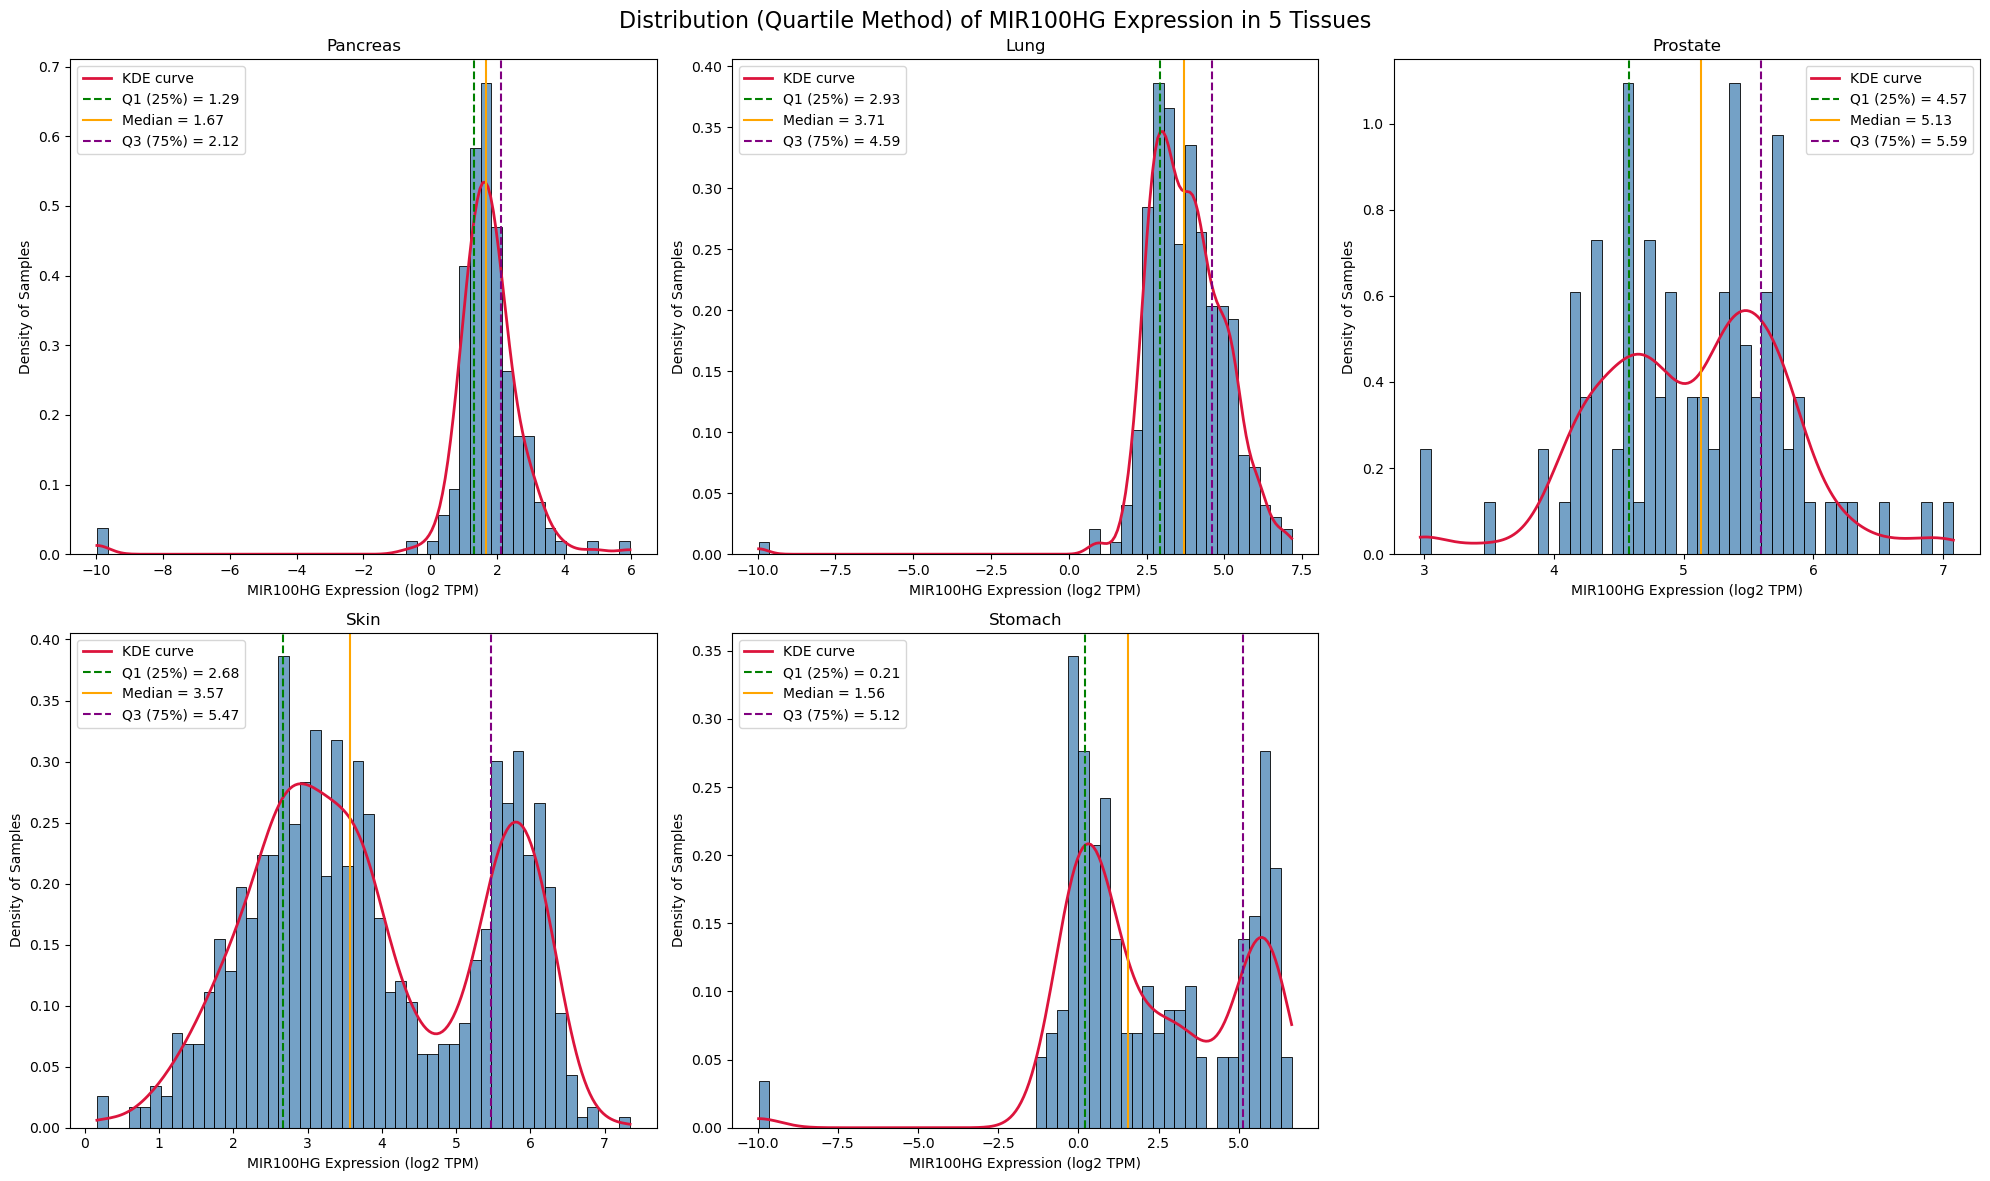

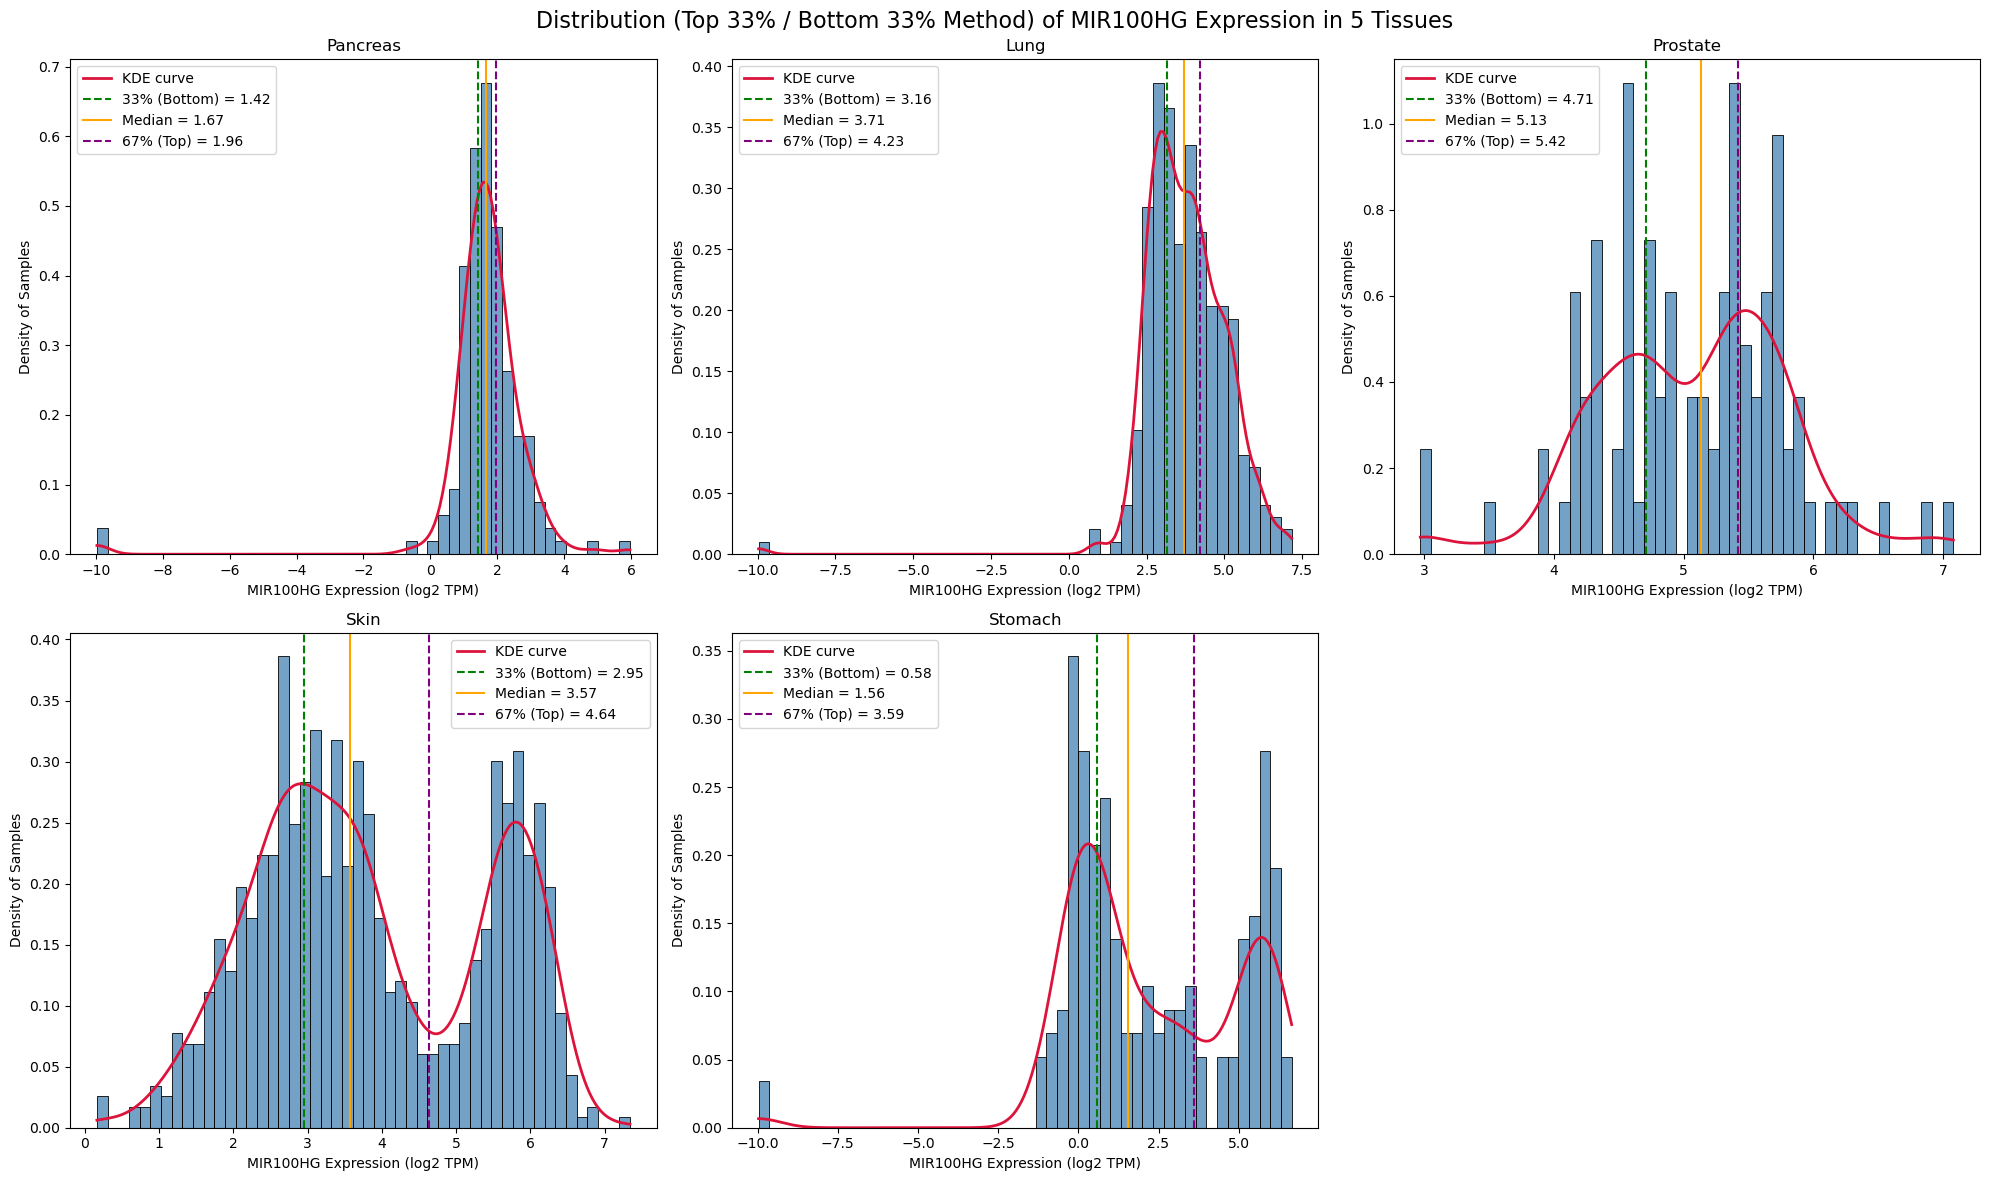

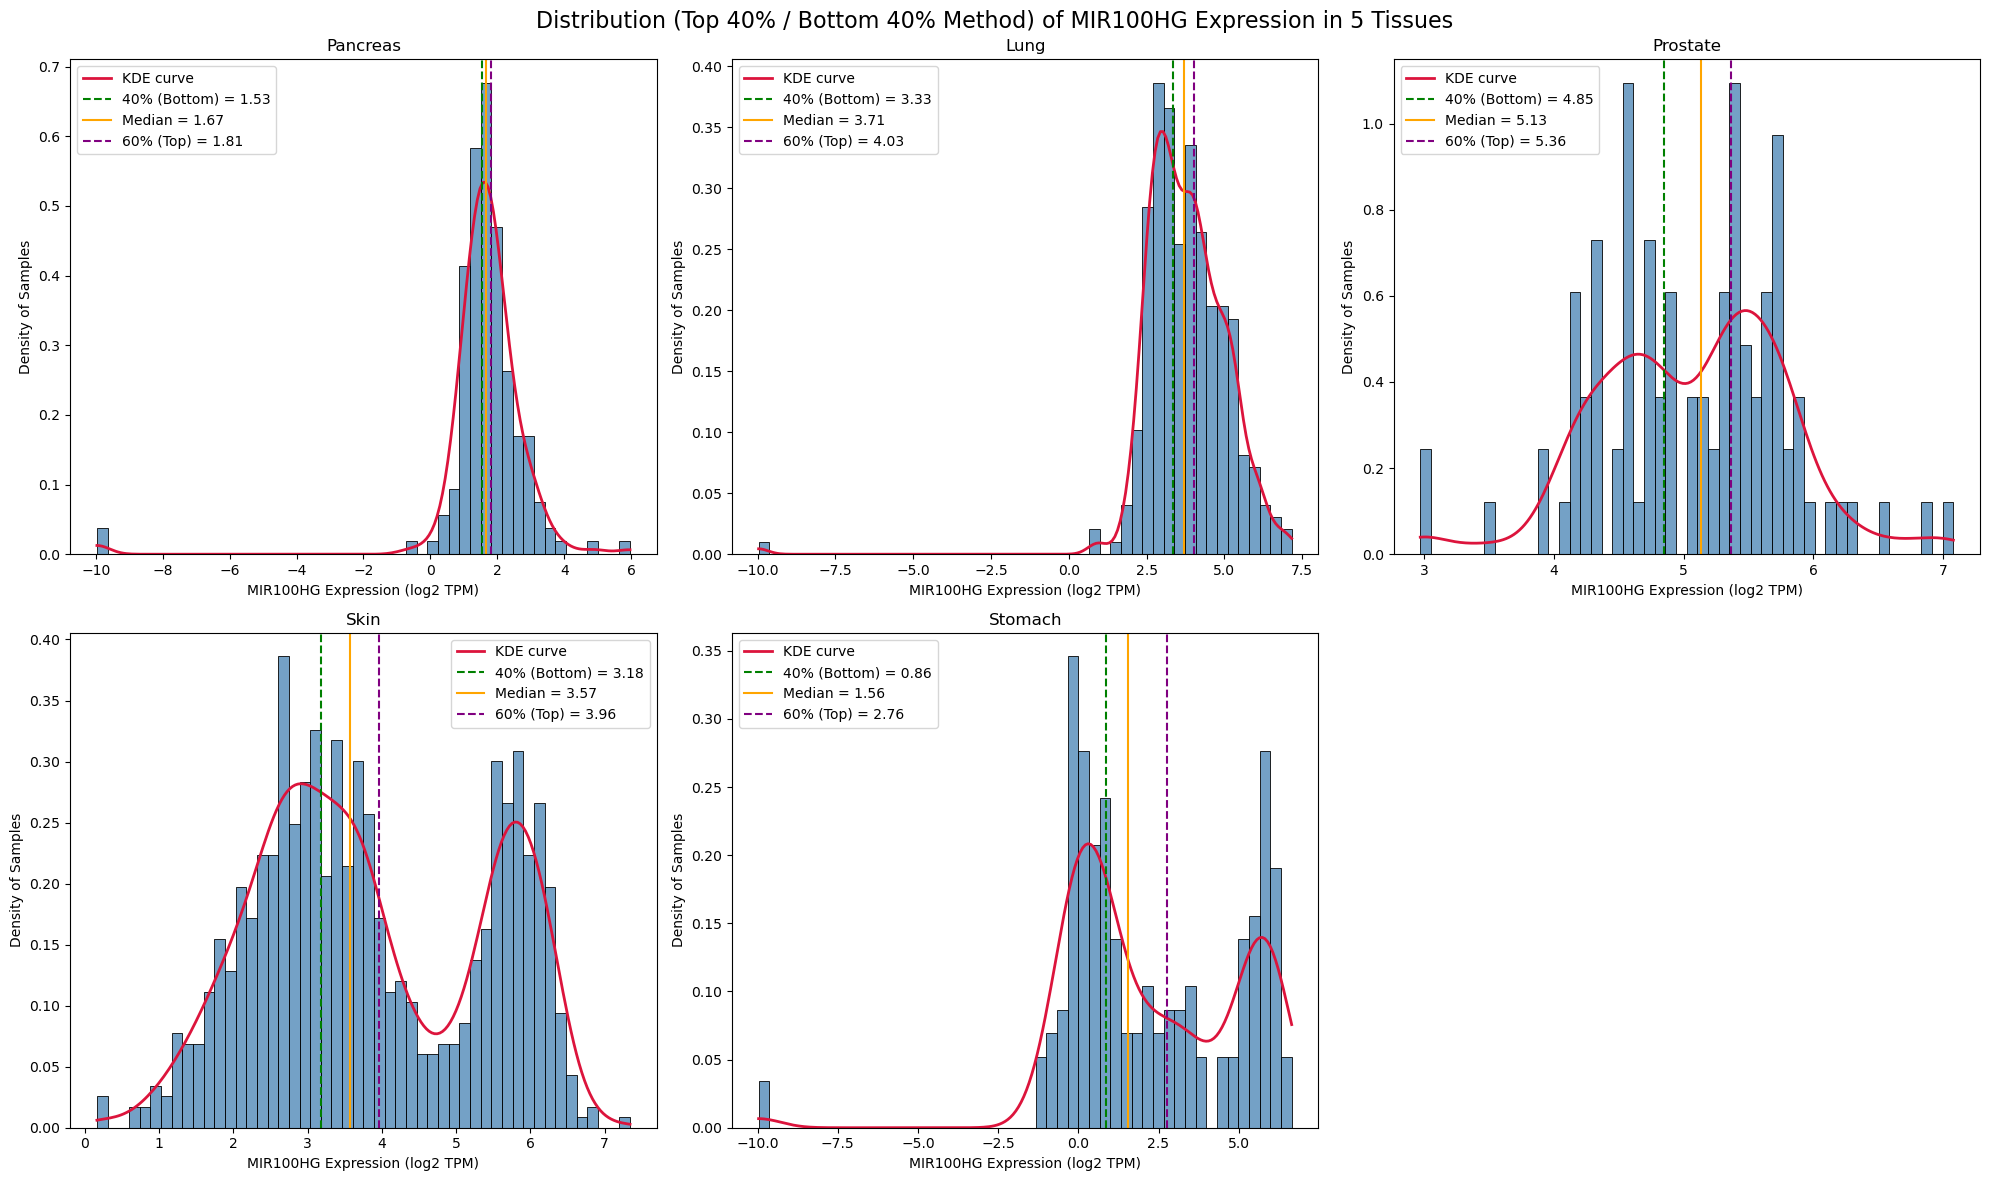

In [10]:
# 1. Define the list of tissue sites to analyze
selected_sites = ["Pancreas", "Lung", "Prostate", "Skin", "Stomach"]

# 2. Initialize dictionaries to store grouping results for each method
quartile_extremes_data = {}
top33_extremes_data = {}
top40_extremes_data = {}

# 3. efine a helper function for quartile-based grouping of MIR100HG expression
def quartile_grouping(expr_vals):
    # Label samples as High (≥Q3), Low (≤Q1), or Discarded based on expression quartiles
    q1_val = expr_vals.quantile(0.25)
    median_val = expr_vals.median()
    q3_val = expr_vals.quantile(0.75)
    labels = []
    for val in expr_vals:
        if val >= q3_val:
            labels.append("High")
        elif val <= q1_val:
            labels.append("Low")
        else:
            labels.append("Discarded")
    df_labeled = pd.DataFrame({
        "Sample": expr_vals.index,
        "MIR100HG_Expression": expr_vals.values,
        "MIR100HG_Expression_Level": labels
    })
    df_extremes = df_labeled[df_labeled["MIR100HG_Expression_Level"].isin(["High", "Low"])]
    n_high = (expr_vals >= q3_val).sum()
    n_low = (expr_vals <= q1_val).sum()
    n_discarded = len(expr_vals) - n_high - n_low
    return df_labeled, df_extremes, (q1_val, median_val, q3_val, n_high, n_low, n_discarded)

# 4. Define a helper function for top/bottom percentage-based grouping of MIR100HG expression
def percentage_grouping(expr_vals, top_percent=0.33, bottom_percent=0.33):
    # Label samples based on top and bottom percentage quantiles
    lower_thresh = expr_vals.quantile(bottom_percent)
    upper_thresh = expr_vals.quantile(1.0 - top_percent)
    labels = []
    for val in expr_vals:
        if val >= upper_thresh:
            labels.append("High")
        elif val <= lower_thresh:
            labels.append("Low")
        else:
            labels.append("Discarded")
    df_labeled = pd.DataFrame({
        "Sample": expr_vals.index,
        "MIR100HG_Expression": expr_vals.values,
        "MIR100HG_Expression_Level": labels
    })
    df_extremes = df_labeled[df_labeled["MIR100HG_Expression_Level"].isin(["High", "Low"])]
    n_high = (expr_vals >= upper_thresh).sum()
    n_low = (expr_vals <= lower_thresh).sum()
    n_discarded = len(expr_vals) - n_high - n_low
    return df_labeled, df_extremes, (lower_thresh, expr_vals.median(), upper_thresh,
                                     n_high, n_low, n_discarded)

# 5. Define a helper function to visualize the expression distribution for each site
def plot_expression_distribution(ax, expr_vals, thresholds, threshold_labels, site_name):
    # Plot histogram and KDE of MIR100HG expression with vertical threshold lines
    sns.histplot(
        expr_vals,
        bins=50,
        color="SteelBlue",
        stat="density",
        kde=False,
        ax=ax
    )
    sns.kdeplot(
        expr_vals,
        color='crimson',
        linewidth=2,
        cut=0,
        bw_adjust=0.7,
        label='KDE curve',
        ax=ax
    )
    for t_val, t_label in zip(thresholds, threshold_labels):
        ax.axvline(x=t_val, color=t_label["color"], linestyle=t_label["linestyle"],
                   label=f"{t_label['label']} = {t_val:.2f}")
    ax.set_xlabel("MIR100HG Expression (log2 TPM)")
    ax.set_ylabel("Density of Samples")
    ax.set_title(site_name)
    ax.legend(loc="best")

# 6. Perform grouping for each tissue and print summary statistics
for site in selected_sites:
    print(f"\n{site} Summary:\n")
    df_site = site_to_data[site]
    mir100hg_vals = df_site["MIR100HG_Expression"].astype(float).dropna()

    # Apply quartile-based grouping
    _, df_quart_extremes, quart_info = quartile_grouping(mir100hg_vals)
    q1_val, median_val, q3_val, n_high, n_low, n_discarded = quart_info
    quartile_extremes_data[site] = df_quart_extremes
    print(" -- Quartile-based Grouping Method --")
    print(f" Q1 = {q1_val:.2f}, Median = {median_val:.2f}, Q3 = {q3_val:.2f}")
    print(f" High  : {n_high} samples")
    print(f" Low   : {n_low} samples")
    print(f" Discarded (middle) : {n_discarded} samples\n")

    # Apply 33% top/bottom grouping
    _, df_33_extremes, info_33 = percentage_grouping(mir100hg_vals, top_percent=0.33, bottom_percent=0.33)
    lower_33, med_33, upper_33, n_high_33, n_low_33, n_discarded_33 = info_33
    top33_extremes_data[site] = df_33_extremes
    print(" -- Top 33% / Bottom 33% Grouping Method --")
    print(f" lower threshold = {lower_33:.2f}, upper threshold = {upper_33:.2f}")
    print(f" High  : {n_high_33} samples")
    print(f" Low   : {n_low_33} samples")
    print(f" Discarded (middle) : {n_discarded_33} samples\n")

    # Apply 40% top/bottom grouping
    _, df_40_extremes, info_40 = percentage_grouping(mir100hg_vals, top_percent=0.40, bottom_percent=0.40)
    lower_40, med_40, upper_40, n_high_40, n_low_40, n_discarded_40 = info_40
    top40_extremes_data[site] = df_40_extremes
    print(" -- Top 40% / Bottom 40% Grouping Method --")
    print(f" lower threshold = {lower_40:.2f}, upper threshold = {upper_40:.2f}")
    print(f" High  : {n_high_40} samples")
    print(f" Low   : {n_low_40} samples")
    print(f" Discarded (middle) : {n_discarded_40} samples \n")
    

# 7. Generate visualization for Quartile-based grouping across all tissues
fig_quart, axes_quart = plt.subplots(2, 3, figsize=(20, 12))
axes_quart = axes_quart.flatten()
for i, site in enumerate(selected_sites):
    df_site = site_to_data[site]
    mir100hg_vals = df_site["MIR100HG_Expression"].astype(float).dropna()
    q1_val = mir100hg_vals.quantile(0.25)
    median_val = mir100hg_vals.median()
    q3_val = mir100hg_vals.quantile(0.75)
    thresholds = [q1_val, median_val, q3_val]
    threshold_labels = [
        {"label": "Q1 (25%)", "color": "green",  "linestyle": "--"},
        {"label": "Median",   "color": "orange", "linestyle": "-"},
        {"label": "Q3 (75%)", "color": "purple", "linestyle": "--"}
    ]
    plot_expression_distribution(
        ax=axes_quart[i],
        expr_vals=mir100hg_vals,
        thresholds=thresholds,
        threshold_labels=threshold_labels,
        site_name=site
    )
axes_quart[-1].set_visible(False)
fig_quart.suptitle("Distribution (Quartile Method) of MIR100HG Expression in 5 Tissues", fontsize=16)
plt.tight_layout()
plt.show()

# 8. Generate visualization for Top 33% / Bottom 33% grouping
fig_33, axes_33 = plt.subplots(2, 3, figsize=(20, 12))
axes_33 = axes_33.flatten()
for i, site in enumerate(selected_sites):
    df_site = site_to_data[site]
    mir100hg_vals = df_site["MIR100HG_Expression"].astype(float).dropna()
    lower_33_val = mir100hg_vals.quantile(0.33)
    median_val = mir100hg_vals.median()
    upper_33_val = mir100hg_vals.quantile(0.67)
    thresholds = [lower_33_val, median_val, upper_33_val]
    threshold_labels = [
        {"label": "33% (Bottom)", "color": "green",  "linestyle": "--"},
        {"label": "Median",       "color": "orange", "linestyle": "-"},
        {"label": "67% (Top)",    "color": "purple", "linestyle": "--"}
    ]
    plot_expression_distribution(
        ax=axes_33[i],
        expr_vals=mir100hg_vals,
        thresholds=thresholds,
        threshold_labels=threshold_labels,
        site_name=site
    )
axes_33[-1].set_visible(False)
fig_33.suptitle("Distribution (Top 33% / Bottom 33% Method) of MIR100HG Expression in 5 Tissues", fontsize=16)
plt.tight_layout()
plt.show()

# 9. Generate visualization for Top 40% / Bottom 40% grouping
fig_40, axes_40 = plt.subplots(2, 3, figsize=(20, 12))
axes_40 = axes_40.flatten()
for i, site in enumerate(selected_sites):
    df_site = site_to_data[site]
    mir100hg_vals = df_site["MIR100HG_Expression"].astype(float).dropna()
    lower_40_val = mir100hg_vals.quantile(0.40)
    median_val = mir100hg_vals.median()
    upper_40_val = mir100hg_vals.quantile(0.60)
    thresholds = [lower_40_val, median_val, upper_40_val]
    threshold_labels = [
        {"label": "40% (Bottom)", "color": "green",  "linestyle": "--"},
        {"label": "Median",       "color": "orange", "linestyle": "-"},
        {"label": "60% (Top)",    "color": "purple", "linestyle": "--"}
    ]
    plot_expression_distribution(
        ax=axes_40[i],
        expr_vals=mir100hg_vals,
        thresholds=thresholds,
        threshold_labels=threshold_labels,
        site_name=site
    )
axes_40[-1].set_visible(False)
fig_40.suptitle("Distribution (Top 40% / Bottom 40% Method) of MIR100HG Expression in 5 Tissues", fontsize=16)
plt.tight_layout()
plt.show()

### Section 4: Differential Expression Profiling of MIR100HG-Associated Transcriptomes Across Tissues

#### Subsection 4.1: Differential Expression and Volcano Plot Analysis for MIR100HG High vs. Low Groups

In this subsection, we conduct differential expression (DE) analysis between MIR100HG high and low expression subgroups across five tissue types using three grouping strategies: quartile (Q1/Q4), top/bottom 33%, and top/bottom 40%.

For each tissue and method, we compare gene-level expression profiles using Welch’s t-test, compute log2 fold changes, and adjust p-values via the Benjamini-Hochberg procedure. The results are visualized using volcano plots, and DE gene counts are summarized to assess the consistency and strength of MIR100HG-associated regulatory signals across grouping strategies.

In [14]:
# 1. Build per-site expression matrices for DE analysis
site_expr_data = {}
for site in selected_sites:
    site_sample_ids = [pid for pid, s in patient_to_site.items() if s == site]
    valid_sample_ids = [sid for sid in site_sample_ids if sid in expression_data.columns]
    df_expr_site = expression_data[["HGNC_symbol"] + valid_sample_ids].copy()
    df_expr_site = df_expr_site.set_index("HGNC_symbol")
    site_expr_data[site] = df_expr_site

# 2. Define DE analysis function using Welch’s t-test and FDR correction
def perform_de_analysis(df_expr, high_samples, low_samples):
    results = []
    for gene_id, row in df_expr.iterrows():
        gene_name = row["HGNC_symbol"] if "HGNC_symbol" in df_expr.columns else gene_id
        high_vals = row[high_samples].astype(float)
        low_vals  = row[low_samples].astype(float)
        if len(high_vals) == 0 or len(low_vals) == 0:
            continue
        sd_high = np.std(high_vals)
        sd_low  = np.std(low_vals)
        if sd_high < 1e-6 or sd_low < 1e-6:
            continue
        t_stat, p_val = ttest_ind(high_vals, low_vals, equal_var=False)
        log2_fc = np.mean(high_vals) - np.mean(low_vals)
        results.append([gene_name, log2_fc, p_val])
    df_de = pd.DataFrame(results, columns=["Gene", "log2FC", "pval"])
    df_de["padj"] = multipletests(df_de["pval"], method="fdr_bh")[1]
    return df_de

# 3. Summary function to count significant DE genes
def summarize_degs(df_de):
    cond_up = (df_de["padj"] < 0.05) & (df_de["log2FC"] >= 1)
    cond_down = (df_de["padj"] < 0.05) & (df_de["log2FC"] <= -1)
    num_up = cond_up.sum()
    num_down = cond_down.sum()
    num_total = num_up + num_down
    return num_up, num_down, num_total

# 4. Initialize result containers
df_de_quartile = {}
df_de_33 = {}
df_de_40 = {}

# 5. Run DE analysis per site and grouping method
for site in selected_sites:
    print(f"\nSummary of DEGs in {site}:\n")

    df_expr = site_expr_data[site].drop(columns=["HGNC_symbol"], errors="ignore")

    # Quartile method
    df_quart = quartile_extremes_data[site]
    high_samples_quart = df_quart[df_quart["MIR100HG_Expression_Level"] == "High"]["Sample"].tolist()
    low_samples_quart  = df_quart[df_quart["MIR100HG_Expression_Level"] == "Low"]["Sample"].tolist()
    df_de_Q = perform_de_analysis(df_expr, high_samples_quart, low_samples_quart)
    df_de_quartile[site] = df_de_Q
    up_Q, down_Q, total_Q = summarize_degs(df_de_Q)

    # Top 33% / Bottom 33% method
    df_33 = top33_extremes_data[site]
    high_samples_33 = df_33[df_33["MIR100HG_Expression_Level"] == "High"]["Sample"].tolist()
    low_samples_33  = df_33[df_33["MIR100HG_Expression_Level"] == "Low"]["Sample"].tolist()
    df_de_33pct = perform_de_analysis(df_expr, high_samples_33, low_samples_33)
    df_de_33[site] = df_de_33pct
    up_33, down_33, total_33 = summarize_degs(df_de_33pct)

    # Top 40% / Bottom 40% method
    df_40 = top40_extremes_data[site]
    high_samples_40 = df_40[df_40["MIR100HG_Expression_Level"] == "High"]["Sample"].tolist()
    low_samples_40  = df_40[df_40["MIR100HG_Expression_Level"] == "Low"]["Sample"].tolist()
    df_de_40pct = perform_de_analysis(df_expr, high_samples_40, low_samples_40)
    df_de_40[site] = df_de_40pct
    up_40, down_40, total_40 = summarize_degs(df_de_40pct)

    # Summary output
    summary_data = {
        "Grouping Method": ["Quartile (Q1/Q4)", "Top/Bottom 33%", "Top/Bottom 40%"],
        "Up Genes": [up_Q, up_33, up_40],
        "Down Genes": [down_Q, down_33, down_40],
        "Total DE Genes": [total_Q, total_33, total_40]
    }
    df_summary_site = pd.DataFrame(summary_data)
    display(df_summary_site)


Summary of DEGs in Pancreas:



,Grouping Method,Up Genes,Down Genes,Total DE Genes
0,Quartile (Q1/Q4),16902,35,16937
1,Top/Bottom 33%,13084,46,13130
2,Top/Bottom 40%,8280,41,8321



Summary of DEGs in Lung:



,Grouping Method,Up Genes,Down Genes,Total DE Genes
0,Quartile (Q1/Q4),4641,3141,7782
1,Top/Bottom 33%,4177,2923,7100
2,Top/Bottom 40%,3322,2724,6046



Summary of DEGs in Prostate:



,Grouping Method,Up Genes,Down Genes,Total DE Genes
0,Quartile (Q1/Q4),2292,1908,4200
1,Top/Bottom 33%,2188,2060,4248
2,Top/Bottom 40%,1908,1997,3905



Summary of DEGs in Skin:



,Grouping Method,Up Genes,Down Genes,Total DE Genes
0,Quartile (Q1/Q4),8382,10708,19090
1,Top/Bottom 33%,7905,10773,18678
2,Top/Bottom 40%,7058,9582,16640



Summary of DEGs in Stomach:



,Grouping Method,Up Genes,Down Genes,Total DE Genes
0,Quartile (Q1/Q4),17898,3013,20911
1,Top/Bottom 33%,16780,2997,19777
2,Top/Bottom 40%,13992,2971,16963


#### Subsection 4.2: Volcano Plot Visualization of Differential Expression in Normal Tissues

In this subsection, we visualize gene-level differential expression results across five normal tissues—Pancreas, Lung, Prostate, Skin, and Stomach—using volcano plots based on the top/bottom 33% MIR100HG expression grouping method. For each tissue, we generate a volcano plot displaying log2 fold change versus −log10 adjusted p-value for all genes. Genes are categorized as Up, Down, or Not Significant using standard statistical thresholds (adjusted p-value < 0.05 and |log2FC| ≥ 1), and colored accordingly to highlight expression shifts associated with high MIR100HG levels.

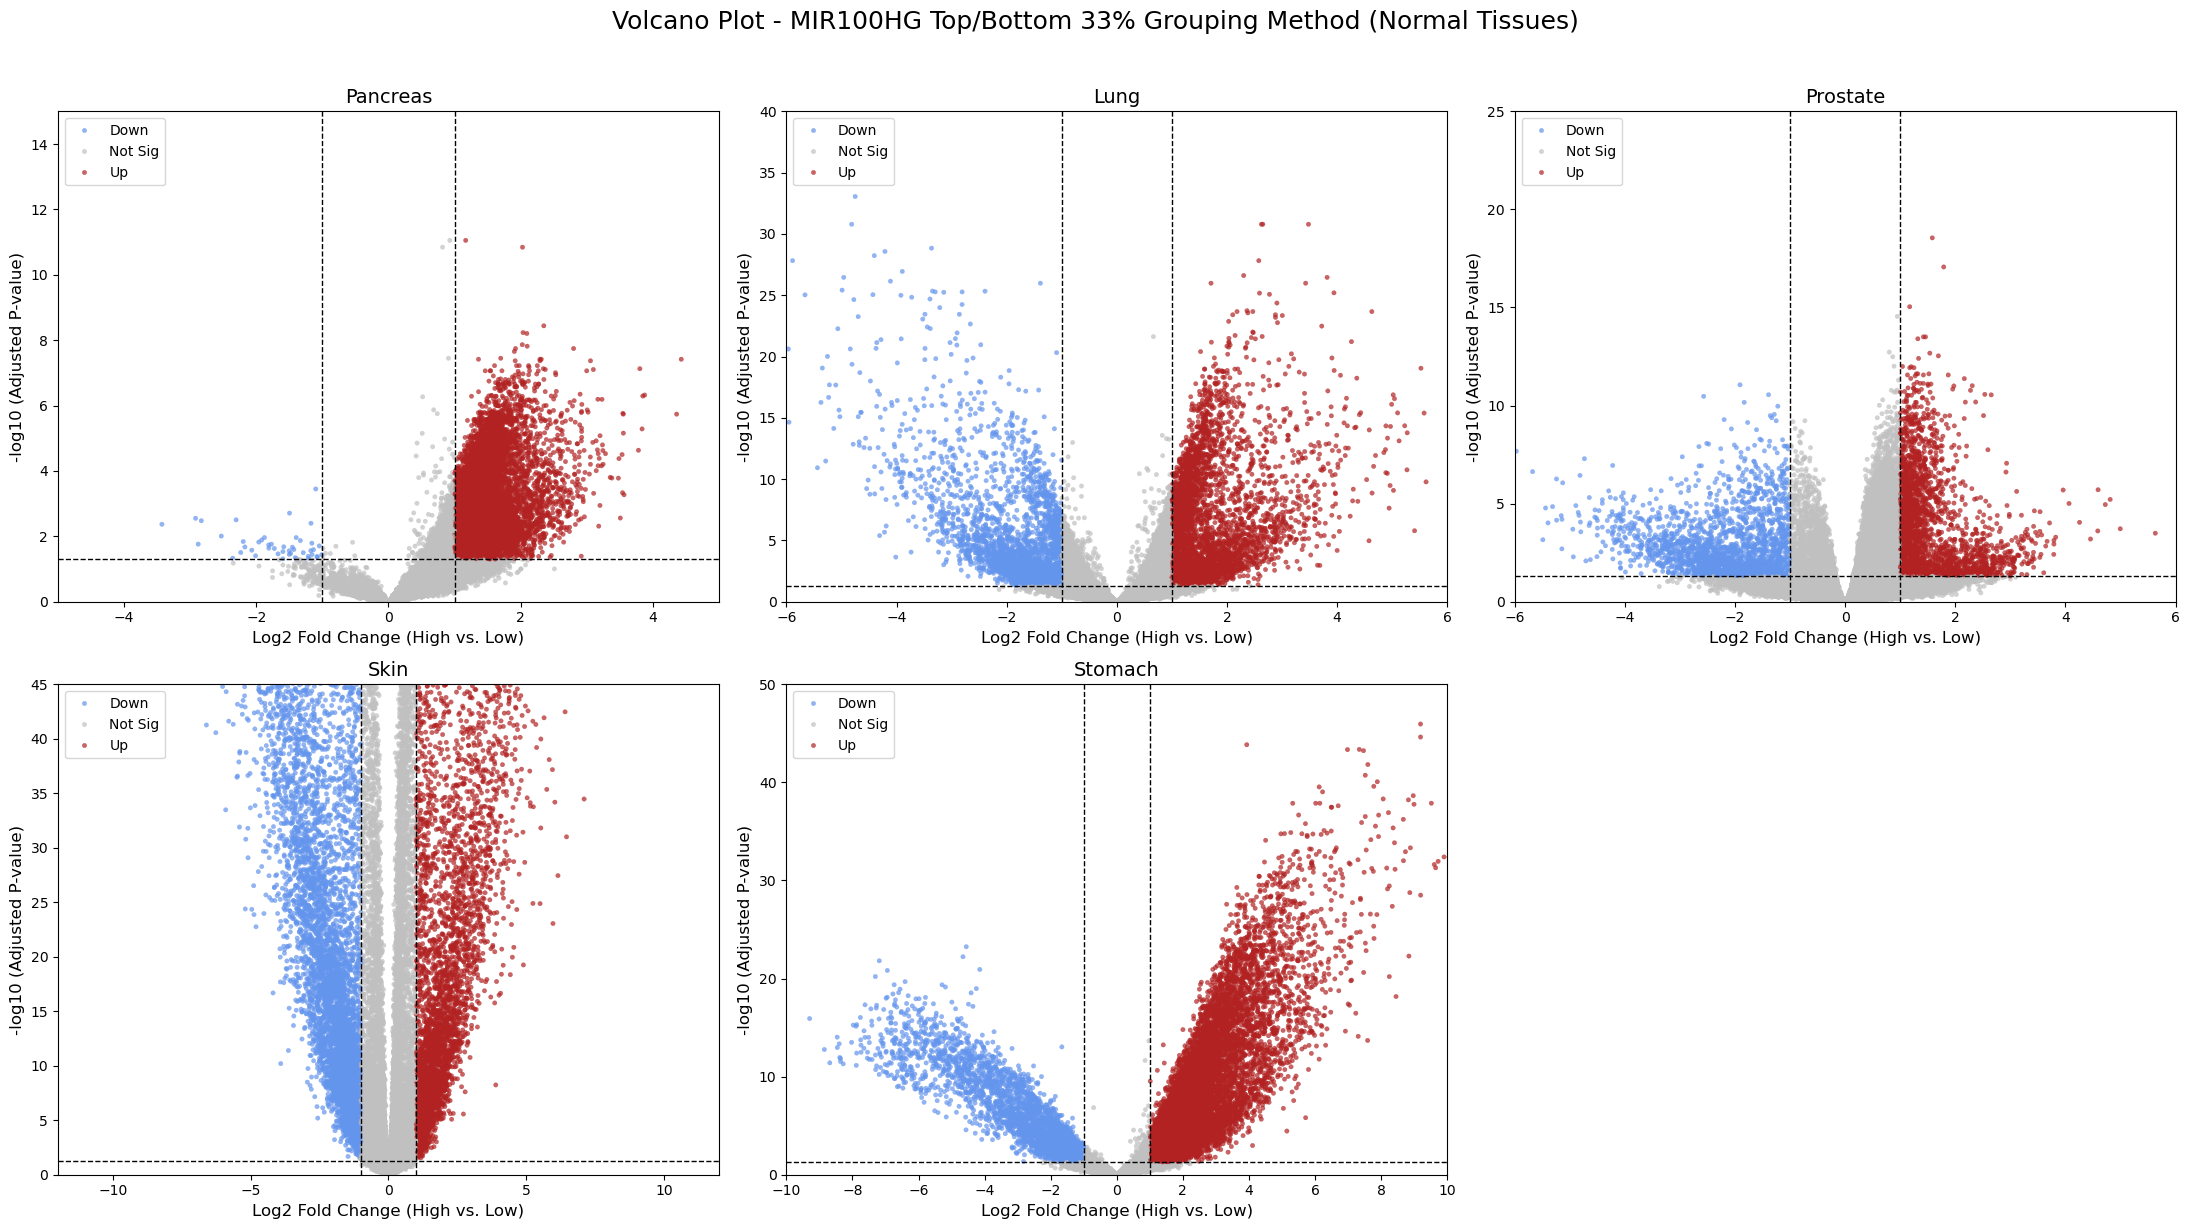

In [17]:
# 1. Collect DE result data and define axis ranges per tissue
de_results_33 = {
    "Pancreas": df_de_33["Pancreas"],
    "Lung": df_de_33["Lung"],
    "Prostate": df_de_33["Prostate"],
    "Skin": df_de_33["Skin"],
    "Stomach": df_de_33["Stomach"]
}

axis_ranges = {
    "Pancreas": {"xlim": (-5, 5), "ylim": 15},
    "Lung":     {"xlim": (-6, 6), "ylim": 40},
    "Prostate": {"xlim": (-6, 6), "ylim": 25},
    "Skin":     {"xlim": (-12, 12), "ylim": 45},
    "Stomach":  {"xlim": (-10, 10), "ylim": 50}
}

# 2. Set up figure with 2 rows and 3 columns for 5 subplots
fig, axes = plt.subplots(2, 3, figsize=(22, 12))
axes = axes.flatten()

# 3. Define volcano plotting function for a given axis
def draw_volcano_on_ax(ax, df_de, tissue_name, xlim, ylim):
    # Calculate -log10(padj)
    df_de["neg_log10_padj"] = -np.log10(df_de["padj"] + 1e-50)

    # Classify genes by significance and fold change
    def classify_gene(row):
        if (row["padj"] < 0.05) and (row["log2FC"] >= 1):
            return "Up"
        elif (row["padj"] < 0.05) and (row["log2FC"] <= -1):
            return "Down"
        else:
            return "Not Sig"
    df_de["Significance"] = df_de.apply(classify_gene, axis=1)

    # Color mapping
    palette_dict = {
        "Down": "cornflowerblue",
        "Not Sig": "silver",
        "Up": "firebrick"
    }

    # Scatter plot
    sns.scatterplot(
        data=df_de,
        x="log2FC",
        y="neg_log10_padj",
        hue="Significance",
        palette=palette_dict,
        hue_order=["Down", "Not Sig", "Up"],
        alpha=0.7,
        s=10,
        edgecolor=None,
        ax=ax
    )

    # Add significance thresholds
    ax.axhline(y=-np.log10(0.05), color="black", linestyle="--", linewidth=1)
    ax.axvline(x=1, color="black", linestyle="--", linewidth=1)
    ax.axvline(x=-1, color="black", linestyle="--", linewidth=1)

    # Set axis labels, limits, and title
    ax.set_title(tissue_name, fontsize=14)
    ax.set_xlabel("Log2 Fold Change (High vs. Low)", fontsize=12)
    ax.set_ylabel("-log10 (Adjusted P-value)", fontsize=12)
    ax.set_xlim(xlim)
    ax.set_ylim(0, ylim)

    # Set SKCM y-ticks step=5 if needed
    if tissue_name == "Skin":
        ax.set_yticks(np.arange(0, ylim + 1, 5))
    
    # Custom x-ticks for Stomach
    if tissue_name == "Stomach":
        ax.set_xticks(np.arange(xlim[0], xlim[1] + 1, 2))

    ax.legend(title=None, loc="upper left", fontsize=10)

# 4. Loop through tissues and draw volcano plots
for i, (tissue, df_de) in enumerate(de_results_33.items()):
    xlim = axis_ranges[tissue]["xlim"]
    ylim = axis_ranges[tissue]["ylim"]
    draw_volcano_on_ax(axes[i], df_de.copy(), tissue, xlim, ylim)

axes[-1].set_visible(False)
fig.suptitle("Volcano Plot - MIR100HG Top/Bottom 33% Grouping Method (Normal Tissues)", fontsize=18, y=1.02)

# 5. Display the figure
plt.tight_layout()
plt.show()

#### Subsection 4.3: Cross-Tissue Summary of Differential Expression Results

In this subsection, we summarize and visualize the number of differentially expressed genes (DEGs) identified using three expression grouping strategies—quartile, top/bottom 33%, and top/bottom 40% — across five tissue types.
For each site and method, we aggregate the number of significant upregulated and downregulated genes (adjusted p-value < 0.05 and |log2FC| ≥ 1), and then generate a comparative bar plot to evaluate how grouping strategies influence DEG discovery.

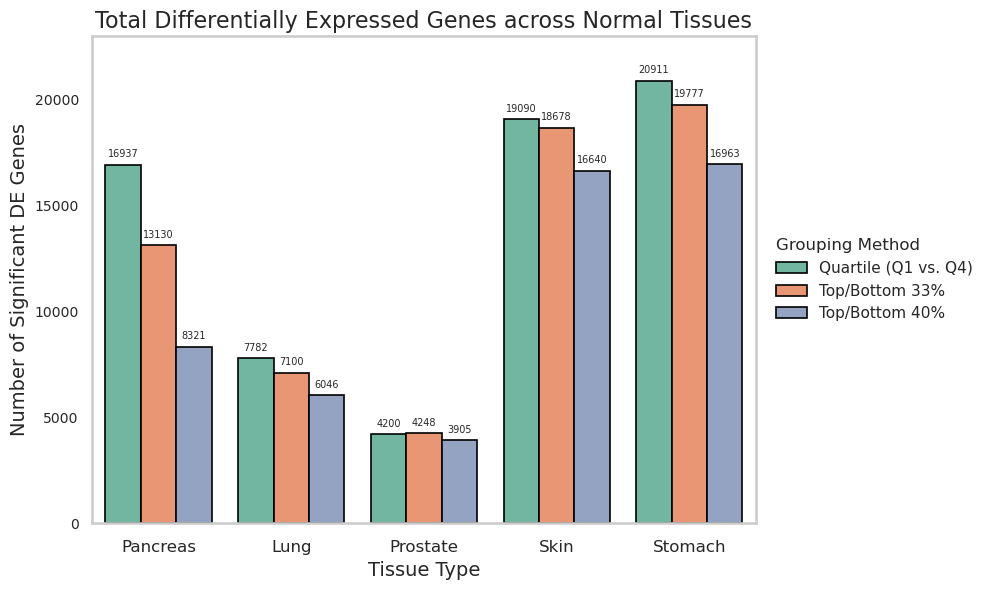

In [21]:
# 1: Build summary table across all tissues and grouping strategies
summary_list = []

for site in selected_sites:
    # Summarize DEGs for quartile method
    up_q, down_q, total_q = summarize_degs(df_de_quartile[site])
    
    # Summarize DEGs for top/bottom 33% method
    up_33, down_33, total_33 = summarize_degs(df_de_33[site])
    
    # Summarize DEGs for top/bottom 40% method
    up_40, down_40, total_40 = summarize_degs(df_de_40[site])

    # Combine into DataFrame
    df = pd.DataFrame({
        "Site": site,
        "Grouping Method": ["Quartile (Q1 vs. Q4)", "Top/Bottom 33%", "Top/Bottom 40%"],
        "Total DEGs": [total_q, total_33, total_40],
        "Up Genes": [up_q, up_33, up_40],
        "Down Genes": [down_q, down_33, down_40]
    })

    # Append to summary list
    summary_list.append(df)

# Concatenate summaries into a single DataFrame
df_all_summary = pd.concat(summary_list, ignore_index=True)

# 2: Create a bar plot comparing total DEG counts across methods and tissues
with sns.axes_style("whitegrid"), sns.plotting_context("talk"):
    fig, ax = plt.subplots(figsize=(10, 6))

    # Draw grouped barplot
    bars = sns.barplot(
        data=df_all_summary,
        x="Site",
        y="Total DEGs",
        hue="Grouping Method",
        palette="Set2",
        edgecolor="black",
        linewidth=1.2,
        ax=ax
    )
    ax.spines['left'].set_visible(True)

    # Customize axis labels and title
    ax.set_ylabel("Number of Significant DE Genes", fontsize=14)
    ax.set_xlabel("Tissue Type", fontsize=14)
    ax.set_title("Total Differentially Expressed Genes across Normal Tissues", fontsize=16)

    # Adjust tick font sizes
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=10)
    ax.tick_params(axis='y', which='major', length=6, width=1.2, direction='out')

    # Turn off background grid
    ax.grid(False)

    # Show value on top of each bar
    for p in bars.patches:
        height = p.get_height()
        if height > 0:
            ax.annotate(
                f"{int(height)}",
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom',
                fontsize=7,
                xytext=(0, 4),
                textcoords='offset points'
            )

    # Set y-axis limits and ticks manually
    ax.set_ylim(0, 23000)
    ax.set_yticks(range(0, 23000, 5000))

    
    # Adjust legend
    ax.legend(
        title="Grouping Method",
        title_fontsize=12,
        fontsize=11,
        loc="center left",
        bbox_to_anchor=(1.01, 0.5),
        frameon=False,
        alignment="left"
    )
    
# 5. Display the figure
plt.tight_layout()
plt.show()

### Section 5: Final Integration of MIR100HG-Driven Gene Expression and Clinical Metadata Across Five Tissue Types

In this section, we begin by loading and processing GTEx/TCGA phenotype and expression data, identify genes downstream of MIR100HG using regulatory edges, and extract their expression across five tissues. We then group samples into 'High' and 'Low' expression classes using a top/bottom 33% strategy. Finally, we generate or load standardized per-tissue Excel files, including gender, regulatory gene features, and sample metadata, ready for downstream classification or regression analyses.

In [24]:
# 1. Load phenotype metadata file
phenotype_file = "TOIL_GTEX_PHENOTYPE_5_CANCERS.csv"
clinic_data = pd.read_csv(phenotype_file)

required_columns = {"Primary_site", "Sample"}
if not required_columns.issubset(clinic_data.columns):
    raise ValueError(
        f"Missing required columns in the phenotype CSV file: {required_columns - set(clinic_data.columns)}"
    )

# Create mapping from tissue site to list of patient sample IDs
tissue_site_to_patient = clinic_data.groupby("Primary_site")["Sample"].apply(list).to_dict()

# 2. Load expression matrix (rows = genes, columns = samples)
expression_file = "TOIL_GTEX_RSEM_TPM_5_CANCERS.csv"
expression_data = pd.read_csv(expression_file, index_col=0)

# Extract MIR100HG expression row
mir100hg_data = expression_data[expression_data["HGNC_symbol"] == "MIR100HG"]
patient_ids = mir100hg_data.columns[2:].tolist()

# Create mapping from sample ID to tissue site and gender
patient_to_site = clinic_data.set_index("Sample")["Primary_site"].to_dict()
patient_to_gender = clinic_data.set_index("Sample")["Gender"].to_dict()

# 3. Load TF-target gene edges and filter for edges where MIR100HG is the source
filename = 'gene_attribute_edges.txt'
df_tf = pd.read_csv(filename, sep='\t', skiprows=1, usecols=[0, 2, 3, 5, 6])
df_tf.columns = ['SourceGeneSym', 'SourceGeneID', 'TargetGeneSym', 'TargetGeneID', 'weight']
mir100hg_rows = df_tf[df_tf['SourceGeneSym'] == 'MIR100HG']

# Get expression of MIR100HG and its downstream genes
mir100hg_data = expression_data[expression_data["HGNC_symbol"] == "MIR100HG"]
related_genes = mir100hg_rows['TargetGeneSym']
related_gene_expr = expression_data[expression_data["HGNC_symbol"].isin(related_genes)]

# Format expression matrix: genes as columns, patients as rows
related_gene_expr = related_gene_expr.set_index("HGNC_symbol")
X = related_gene_expr.iloc[:, 1:].T
X.index.name = "Patient_ID"
X.columns.name = None

# Format MIR100HG expression the same way
y = mir100hg_data.iloc[:, 2:].T
y.columns = ["MIR100HG_Expression"]
y.index.name = "Patient_ID"

# 4. Join predictors and target into one DataFrame
data = X.join(y, how="inner")

# Subset data by tissue site and append gender as binary feature
selected_sites = ["Pancreas", "Lung", "Prostate", "Skin", "Stomach"]
site_to_data = {}

for site in selected_sites:
    site_patient_ids = [pid for pid, s in patient_to_site.items() if s == site]
    site_data = data.loc[data.index.isin(site_patient_ids)].copy()
    site_data["Gender"] = site_data.index.map(patient_to_gender)
    site_data["Gender"] = site_data["Gender"].map({"male": 1, "female": 0})
    site_data.dropna(inplace=True)
    site_to_data[site] = site_data

# 5. Define function to perform top/bottom 33% expression grouping
def percentage_grouping(expr_vals, top_percent=0.33, bottom_percent=0.33):
    # Label samples as High, Low, or Discarded based on expression quantiles
    lower_thresh = expr_vals.quantile(bottom_percent)
    upper_thresh = expr_vals.quantile(1.0 - top_percent)
    labels = []
    for val in expr_vals:
        if val >= upper_thresh:
            labels.append("High")
        elif val <= lower_thresh:
            labels.append("Low")
        else:
            labels.append("Discarded")
    df_labeled = pd.DataFrame({
        "Sample": expr_vals.index,
        "MIR100HG_Expression": expr_vals.values,
        "MIR100HG_Expression_Level": labels
    })
    df_extremes = df_labeled[df_labeled["MIR100HG_Expression_Level"].isin(["High", "Low"])]
    return df_labeled, df_extremes

# 6. Apply 33% grouping to each site and store extreme samples only
top33_extremes_data = {}

for site in selected_sites:
    df_site = site_to_data[site]
    mir100hg_vals = df_site["MIR100HG_Expression"].astype(float).dropna()
    _, df_33_extremes = percentage_grouping(mir100hg_vals, top_percent=0.33, bottom_percent=0.33)
    top33_extremes_data[site] = df_33_extremes

# 7. Create output directory for final integrated Excel files
final_integration_dir = "Task2_Final_Integration"
os.makedirs(final_integration_dir, exist_ok=True)

# Build or load per-site integrated DataFrame and export
final_site_dfs = {}

for site in selected_sites:
    output_excel_path = os.path.join(final_integration_dir, f"Final_Integration_{site}.xlsx")
    
    if os.path.exists(output_excel_path):
        print(f"File '{output_excel_path}' already exists. Loading it directly...")
        df_loaded = pd.read_excel(output_excel_path)
        final_site_dfs[site] = df_loaded
        print(f"Loaded DataFrame for {site}. Shape: {df_loaded.shape}\n")
    
    else:
        print(f"File '{output_excel_path}' not found. Generating from scratch...\n")
        extremes_df = top33_extremes_data[site]
        site_df = site_to_data[site].loc[extremes_df["Sample"]].copy()
        site_df[f"MIR100HG_Expression_Level_{site}"] = (
            extremes_df.set_index("Sample")["MIR100HG_Expression_Level"]
        )
        site_df[f"Patient_ID_{site}"] = site_df.index
        site_df.rename(columns={"MIR100HG_Expression": f"MIR100HG_Expression_{site}"}, inplace=True)

        special_cols = [
            f"Patient_ID_{site}",
            "Gender",
            f"MIR100HG_Expression_{site}",
            f"MIR100HG_Expression_Level_{site}"
        ]
        
        rename_tf_expr_dict = {}
        for col in site_df.columns:
            if col not in special_cols and col.endswith(f"_{site}"):
                gene_name = col[:-len(f"_{site}")]
                rename_tf_expr_dict[col] = f"tf_{gene_name}_expr_{site}"
        
        site_df.rename(columns=rename_tf_expr_dict, inplace=True)

        gene_cols = [c for c in site_df.columns if c not in special_cols]
        new_order = [
            f"Patient_ID_{site}",
            "Gender",
            f"MIR100HG_Expression_{site}",
            f"MIR100HG_Expression_Level_{site}"
        ] + gene_cols
        
        site_df = site_df[new_order].reset_index(drop=True)
        final_site_dfs[site] = site_df

        site_df.to_excel(output_excel_path, index=False)
        print(f"Saved new Final_Integration_{site}.xlsx. Shape: {site_df.shape}\n")

    # Display the resulting DataFrame for inspection
    print(f"Final Integrated DataFrame for {site}:")
    display(final_site_dfs[site].head(10).style.hide(axis="index"))
    print("\n")

File 'Task2_Final_Integration\Final_Integration_Pancreas.xlsx' not found. Generating from scratch...

Saved new Final_Integration_Pancreas.xlsx. Shape: (112, 60)

Final Integrated DataFrame for Pancreas:


Patient_ID_Pancreas,Gender,MIR100HG_Expression_Pancreas,MIR100HG_Expression_Level_Pancreas,ZNF263,BRCA1,KDM4A,TCF3,KDM5A,FOSL2,REST,RCOR1,EP300,YY1,CTCF,MAZ,USF2,NRF1,EZH2,GATA3,SMC3,TBP,NR3C1,ATF2,HDAC1,RBBP5,MXI1,CTCFL,WRNIP1,GTF2F1,MAX,FOXP2,FOXA1,JUND,TRIM28,BHLHE40,MYC,TCF12,RFX5,TAF1,TCF7L2,BACH1,RAD21,ZNF143,PBX3,STAT3,SIN3A,FOS,CHD7,CEBPB,CHD2,TBL1XR1,GATA2,POLR2A,SP1,HDAC2,TEAD4,MAFK,E2F4,CUX1
GTEX_111CU_0526_SM_5EGHK,1,0.978900,Low,2.876000,0.085400,1.989500,3.519900,1.844400,2.561000,1.263600,1.098300,2.457100,3.085900,2.842200,5.151400,5.219200,1.322500,1.417400,-4.293400,2.961800,2.342300,1.856400,2.493400,4.449000,1.422800,3.669100,-9.965800,4.013600,4.726300,3.664600,1.138200,-1.248100,6.145500,6.883500,3.987400,3.913700,2.430600,1.678500,2.705100,2.211300,1.918800,3.583900,2.046500,2.205100,4.963100,2.891600,4.827400,1.029300,3.255700,3.173300,2.909000,2.451800,4.738800,2.924300,4.273600,4.359700,3.826900,4.060100,3.887600
GTEX_111YS_1226_SM_5EGGJ,1,1.293400,Low,2.551100,-0.182800,1.642000,3.281100,1.401100,2.765700,0.911500,1.084700,2.063800,3.035800,2.682800,5.356500,5.162700,1.390100,0.783200,-5.573500,2.711700,2.032500,1.683000,2.114700,4.213400,0.919100,3.136000,-9.965800,3.871900,4.316900,3.360500,0.705800,-2.547900,5.657100,6.485600,3.944000,4.050600,2.028900,1.433500,2.950700,2.108000,1.683000,3.228200,1.460000,2.211300,4.316900,2.233000,5.012200,1.655800,3.549800,3.356300,2.722700,2.480500,4.097700,2.457100,4.106100,4.129400,3.750700,3.881800,3.834000
GTEX_1122O_0726_SM_5GIEV,0,1.339700,Low,2.763600,-0.710800,1.705300,3.437100,1.417400,2.623200,0.911500,1.050300,2.124700,3.434400,2.737900,5.239200,5.384100,1.428100,1.406500,-3.458000,2.718300,2.004000,1.551400,2.025400,4.503400,0.986200,3.649700,-5.011600,4.010900,4.648500,3.246600,0.799900,-2.465900,5.746600,6.718000,3.844100,2.895500,1.960100,1.406500,2.854200,2.081000,1.761700,3.170100,1.599800,2.526300,4.306800,2.364900,4.623600,2.201900,3.126100,3.472600,3.304700,1.974900,4.306000,2.639500,4.157100,4.231200,4.056700,4.170000,4.197800
GTEX_117YX_0226_SM_5EGH6,1,0.379600,Low,2.757200,-0.215900,2.147600,3.451700,2.060400,4.349900,1.227100,1.310900,2.356400,3.363300,2.877900,5.282800,5.530500,1.263600,1.460000,-4.293400,2.996600,1.895700,1.642000,2.347900,4.298000,1.202300,3.828900,-9.965800,3.994700,4.597600,3.625400,0.705800,-2.547900,7.114300,6.611800,5.373700,6.732100,2.319300,1.816000,3.053300,2.528800,1.844400,3.519900,1.856400,2.124700,4.933100,2.669300,8.777900,1.985900,4.549700,3.197100,2.864100,2.451800,4.516100,2.784700,4.375800,4.081600,4.370200,4.232000,4.034000
GTEX_11DXX_0926_SM_5H112,0,1.091500,Low,2.272300,-1.055900,1.678500,3.410200,1.111700,2.150900,0.840800,0.888300,2.091200,3.494500,2.543700,5.185900,5.328800,1.367900,1.362300,-3.171400,2.767900,1.844400,1.595000,2.186200,4.289200,1.091500,3.249600,-9.965800,4.089200,4.653100,3.242000,0.547000,-1.595100,5.616500,6.544600,3.720400,3.220500,1.918800,1.967500,2.170200,1.748900,1.674000,3.063700,2.616100,2.060400,4.142500,2.167000,3.037600,1.322500,3.455600,3.675900,2.729200,2.254300,4.024200,2.275300,3.931800,4.085800,3.673700,4.142500,3.838000
GTEX_11I78_0626_SM_5A5LZ,0,1.269600,Low,2.506100,-0.619300,1.852400,3.225100,1.480800,1.787000,0.537000,1.131600,2.251300,3.228200,2.657900,5.387900,5.513800,1.705300,0.642500,-2.727400,2.702900,2.192500,1.632700,1.914900,4.471900,0.949300,3.370300,-6.506400,3.968200,4.433000,3.144200,0.496700,-3.816000,5.534200,6.322300,3.173300,2.570700,2.000400,1.506400,2.094600,2.441200,1.521600,3.470000,2.094600,2.330800,4.132700,2.356400,5.649900,1.811900,3.263200,3.551000,2.533800,2.503600,3.764600,2.592400,3.923200,3.139300,3.764600,4.238900,3.516100
GTEX_11ILO_1526_SM_5A5KZ,0,3.200200,High,3.263200,-0.886300,2.236000,3.970900,1.753200,3.479100,1.774400,1.963800,2.464900,3.840100,2.926200,5.874100,5.930800,2.070700,1.778600,-3.458000,2.830100,2.551100,2.307700,2.590000,4.929400,1.362300,3.789800,-9.965800,4.292900,4.671900,4.140900,1.824200,-2.244700,5



File 'Task2_Final_Integration\Final_Integration_Lung.xlsx' not found. Generating from scratch...

Saved new Final_Integration_Lung.xlsx. Shape: (190, 60)

Final Integrated DataFrame for Lung:


Patient_ID_Lung,Gender,MIR100HG_Expression_Lung,MIR100HG_Expression_Level_Lung,ZNF263,BRCA1,KDM4A,TCF3,KDM5A,FOSL2,REST,RCOR1,EP300,YY1,CTCF,MAZ,USF2,NRF1,EZH2,GATA3,SMC3,TBP,NR3C1,ATF2,HDAC1,RBBP5,MXI1,CTCFL,WRNIP1,GTF2F1,MAX,FOXP2,FOXA1,JUND,TRIM28,BHLHE40,MYC,TCF12,RFX5,TAF1,TCF7L2,BACH1,RAD21,ZNF143,PBX3,STAT3,SIN3A,FOS,CHD7,CEBPB,CHD2,TBL1XR1,GATA2,POLR2A,SP1,HDAC2,TEAD4,MAFK,E2F4,CUX1
GTEX_111VG_0726_SM_5GIDC,1,6.479300,High,3.691600,0.642500,2.971000,5.340200,3.258700,7.276600,2.345100,4.078200,3.160400,5.104800,3.541100,6.358600,6.559500,3.269200,3.055000,1.183300,3.449000,2.963700,4.239600,4.316900,6.362500,1.015100,4.678100,-6.506400,5.183100,4.656000,6.112100,1.937700,2.860200,8.702300,7.453200,7.903300,6.459800,4.639900,4.311900,3.953400,4.869400,5.115700,5.943900,4.753300,4.523000,7.872200,5.115200,6.227900,4.121100,7.240400,6.747000,4.959400,5.935000,5.318700,3.973700,5.681800,5.393700,7.673000,5.549100,5.337700
GTEX_111YS_0626_SM_5GZXV,1,2.606700,Low,4.654300,1.170600,4.012700,4.791900,3.729100,7.169000,2.490800,4.443700,4.653100,5.241900,4.059300,6.123100,6.893900,3.257200,1.239400,1.454700,4.466700,3.735600,4.398600,4.030400,5.907400,2.556100,5.588600,-5.011600,5.110700,5.178800,6.126000,1.043300,3.326400,7.620400,7.222700,6.552100,5.448300,4.671300,4.000100,4.269900,4.150600,4.204800,6.659500,4.033100,3.872900,7.461600,4.909800,8.322200,3.396600,7.566900,6.076200,4.643900,6.338600,6.022800,4.751700,5.676700,5.224200,6.207300,6.117500,5.451900
GTEX_1122O_0126_SM_5GICA,0,2.226800,Low,4.677600,1.245500,3.987400,4.636400,3.190800,5.512600,2.248200,3.679300,4.144900,4.762400,4.120300,6.579600,7.379400,3.368900,1.465200,2.004000,4.158700,3.653200,3.775200,3.507300,6.124300,2.254300,4.806400,-9.965800,5.319800,5.480600,6.009700,0.323100,2.319300,7.120300,7.734400,5.189900,4.560200,4.238100,4.155500,4.189900,3.835000,3.446400,6.005000,3.577900,3.915600,6.739300,4.363200,7.725800,2.868100,7.077000,5.297200,4.282500,7.040400,5.857500,4.464700,5.391000,4.559600,6.009700,6.330600,5.636400
GTEX_117YW_0526_SM_5H11C,1,6.203400,High,3.921300,-0.166500,3.112900,5.225400,3.647400,6.747300,2.074200,4.182000,3.225100,4.840500,3.499700,6.624300,7.148300,3.173300,3.173300,1.884000,3.237400,3.569400,4.398600,4.248800,6.402800,1.000700,4.796000,-5.011600,4.836500,4.708800,6.575200,0.334600,-0.284500,8.291100,7.320700,6.428800,4.523000,5.026000,4.845000,3.799200,4.839500,4.496400,5.927700,4.245000,4.605300,7.408500,4.764000,5.665400,3.740000,7.171600,6.652600,5.101900,5.745500,5.495400,4.469300,5.270600,4.560800,6.855800,5.450900,5.138000
GTEX_117YX_1326_SM_5H125,1,3.060200,Low,4.519200,1.570900,3.938400,4.915100,3.646300,5.866700,2.967400,4.175600,4.504700,5.270600,4.417600,6.655500,7.297800,3.393800,1.907300,2.359200,4.453600,3.837000,4.271400,4.070500,5.882900,2.669300,5.369900,-6.506400,5.324500,5.558900,5.913900,1.406500,3.564500,7.623400,7.658200,6.093200,5.441000,4.556500,4.625300,4.442300,3.990100,3.840100,6.536800,3.534900,3.889600,7.291900,4.512900,9.345100,3.275200,7.452200,5.330200,4.562600,7.304000,6.093600,4.713800,5.525800,5.059200,6.225400,6.312700,5.472500
GTEX_11DXZ_0726_SM_5N9C4,1,3.068800,Low,4.072200,2.236000,4.341300,5.391300,3.300300,5.056600,2.538800,4.167600,3.770900,4.834000,4.018000,7.007500,7.007300,3.009200,3.724800,1.118400,3.861100,3.592300,3.923200,3.748600,6.274300,1.985900,3.526200,-9.965800,4.828400,5.291300,5.427300,0.911500,3.089300,6.761300,7.998800,6.999100,4.504700,4.139200,5.305600,3.467400,3.708300,3.489400,5.681800,3.634700,4.165200,6.377000,4.006400,7.402400,3.046300,6.235400,5.838700,4.677000,4.824800,6.114600,4.663400,5.295400,4.364600,4.798100,6.163900,5.253300
GTEX_11DZ1_0426_SM_5H11A,1,4.596400,High,4.458800,0.749300,3.475200,5.501800,3.617200,5.931000,2.134500,3.343500,4.162800,4.600000,3.646300,6.403300,7.057200,2.815800,1.599800,1.460000,3.794000,3.399300,3.858100,4.293600,6.160300,1.614000,5.482900,-6.506400,4.760300,5.098500,5.809700,1.655800,0.896100,7.957200,6.899900,7.493700,4.



File 'Task2_Final_Integration\Final_Integration_Prostate.xlsx' not found. Generating from scratch...

Saved new Final_Integration_Prostate.xlsx. Shape: (66, 60)

Final Integrated DataFrame for Prostate:


Patient_ID_Prostate,Gender,MIR100HG_Expression_Prostate,MIR100HG_Expression_Level_Prostate,ZNF263,BRCA1,KDM4A,TCF3,KDM5A,FOSL2,REST,RCOR1,EP300,YY1,CTCF,MAZ,USF2,NRF1,EZH2,GATA3,SMC3,TBP,NR3C1,ATF2,HDAC1,RBBP5,MXI1,CTCFL,WRNIP1,GTF2F1,MAX,FOXP2,FOXA1,JUND,TRIM28,BHLHE40,MYC,TCF12,RFX5,TAF1,TCF7L2,BACH1,RAD21,ZNF143,PBX3,STAT3,SIN3A,FOS,CHD7,CEBPB,CHD2,TBL1XR1,GATA2,POLR2A,SP1,HDAC2,TEAD4,MAFK,E2F4,CUX1
GTEX_111YS_1726_SM_5GIED,1,5.696600,High,4.711000,-0.057400,3.782500,5.117300,3.027000,6.455000,2.446500,3.319200,3.929900,4.582000,4.042700,6.583500,6.862200,3.307600,1.700900,3.766700,3.618400,3.585100,3.588700,3.896400,6.189300,1.996800,5.945400,-6.506400,4.891000,5.386500,5.980000,0.506900,4.864000,7.013500,7.853400,6.713400,6.471000,4.268400,4.901200,3.853100,3.964500,2.753000,5.385800,3.965400,5.044000,6.447600,4.443700,7.817700,2.676000,6.358300,5.671900,4.425700,5.775300,5.806600,3.930800,5.244200,3.245000,6.163500,6.091500,4.860500
GTEX_117YW_1426_SM_5EGGO,1,4.588000,Low,3.966300,0.177600,3.741000,4.425700,2.618500,6.312900,2.160600,3.028700,3.389700,4.288400,3.935600,6.641300,6.354600,2.667000,1.183300,3.418300,3.137700,3.019900,3.641700,3.780400,6.083200,1.864300,4.075600,-4.608200,4.486100,4.882700,5.494800,0.401600,5.627300,8.067700,7.158500,8.765700,4.842500,4.650800,3.631200,3.547300,3.758200,2.546200,5.046200,2.924300,4.530500,5.568100,3.958900,9.667800,2.070700,5.182300,5.546600,4.621200,5.886800,5.453900,3.703900,4.839000,1.412000,5.657100,5.090000,4.921800
GTEX_11DXZ_1826_SM_5H12Y,1,6.151200,High,4.066200,0.808200,3.570600,4.579000,3.136000,5.633200,2.797200,3.080800,4.207200,4.749600,4.278800,6.725600,6.923500,3.255700,0.177600,-2.388400,4.155500,3.702800,4.118600,4.007300,5.961200,2.160600,6.219200,-9.965800,4.793400,5.310000,5.449600,4.275100,-0.554300,6.982000,7.807000,6.947400,4.965800,4.606500,4.823300,3.661200,4.565700,2.903200,6.044200,4.015300,4.794500,6.478200,4.684900,8.145600,0.971600,4.704900,5.071300,4.443700,5.379200,5.043600,4.269900,5.555200,3.881800,6.090200,5.478000,5.747400
GTEX_11O72_2726_SM_5HL6K,1,5.731800,High,4.443700,0.585900,2.971000,4.962600,2.907100,6.904100,2.108000,3.359100,3.200200,4.705500,3.821800,6.591000,7.078300,3.140900,1.465200,3.179700,3.149100,3.766700,3.839100,4.099400,6.511900,2.179800,5.494400,-4.035000,5.057900,5.211800,6.293700,-0.150400,5.640400,7.460600,7.768200,8.775800,5.704900,4.470000,4.318400,3.466100,3.648600,3.201800,5.096800,3.795000,5.208700,7.086700,4.399200,10.329700,2.750800,6.559200,5.632300,4.888100,5.374700,5.466300,3.983800,5.327700,4.010000,6.399400,5.715400,5.321200
GTEX_11OF3_1726_SM_5GU5Q,1,5.522300,High,4.244200,0.252200,3.570600,4.814100,1.911100,4.697200,2.094600,2.414400,3.317700,4.250300,3.672500,6.635000,7.065700,3.155600,0.465700,3.070600,2.876000,3.701700,3.509800,3.652000,6.146100,1.832300,4.352000,-9.965800,4.660600,5.088800,5.655100,0.888300,4.971800,7.139400,7.455300,7.085700,3.772000,4.282500,4.208000,3.200200,3.943100,2.257300,4.591600,3.498400,5.179600,5.390600,3.766700,7.861500,1.334000,5.102300,5.229200,4.325600,6.428800,5.314400,3.473900,4.287000,2.359200,6.233800,5.435300,5.122700
GTEX_11TUW_2126_SM_5GU7B,1,4.697700,Low,4.845000,-0.859900,3.335000,5.247600,2.498500,5.526700,2.000400,2.840200,3.434400,4.030400,3.846100,7.693400,6.454700,3.072300,1.465200,2.449200,2.689500,3.839100,4.121900,3.764600,6.133000,1.937700,4.311100,-9.965800,4.572300,5.656000,5.282800,0.832700,6.503400,6.825900,8.061800,8.393600,5.617400,4.061000,3.944000,3.264700,4.674700,3.399300,4.482900,3.426400,4.064500,7.376900,4.628800,8.122500,2.872000,5.355100,6.070600,4.862000,5.430700,6.031200,3.850100,5.242600,4.126900,6.059400,6.284100,5.486400
GTEX_12C56_1326_SM_5FQSV,1,4.574800,Low,4.759200,0.476100,3.611300,4.539800,3.021700,5.018400,2.803400,2.930000,3.895400,4.470600,3.969100,7.001600,6.714700,3.089300,1.257600,2.074200,3.507300,3.502200,3.435800,3.870000,6.289500,2.322200,5.697100,-3.307600,4.737700,5.765000,5.489000,0.872600,6.960900,6.580900,7.7



File 'Task2_Final_Integration\Final_Integration_Skin.xlsx' not found. Generating from scratch...

Saved new Final_Integration_Skin.xlsx. Shape: (537, 60)

Final Integrated DataFrame for Skin:


Patient_ID_Skin,Gender,MIR100HG_Expression_Skin,MIR100HG_Expression_Level_Skin,ZNF263,BRCA1,KDM4A,TCF3,KDM5A,FOSL2,REST,RCOR1,EP300,YY1,CTCF,MAZ,USF2,NRF1,EZH2,GATA3,SMC3,TBP,NR3C1,ATF2,HDAC1,RBBP5,MXI1,CTCFL,WRNIP1,GTF2F1,MAX,FOXP2,FOXA1,JUND,TRIM28,BHLHE40,MYC,TCF12,RFX5,TAF1,TCF7L2,BACH1,RAD21,ZNF143,PBX3,STAT3,SIN3A,FOS,CHD7,CEBPB,CHD2,TBL1XR1,GATA2,POLR2A,SP1,HDAC2,TEAD4,MAFK,E2F4,CUX1
GTEX_111CU_1126_SM_5EGIM,1,2.364900,Low,4.073900,-0.150400,3.751800,4.917000,3.777300,6.519700,2.118000,3.419700,4.024200,4.613600,3.751800,6.118500,7.132400,2.570700,3.408800,6.977700,3.404800,2.868100,2.709500,2.336600,5.070900,2.316400,5.151800,-9.965800,4.864000,4.878300,5.295400,1.362300,-2.388400,6.956800,7.822400,5.717600,7.086000,2.989300,2.716100,3.788800,3.706100,3.407500,4.759200,3.295900,3.273700,5.629100,4.283300,6.443600,3.630100,6.073600,5.239200,4.020700,3.142600,6.127200,4.529300,4.965400,4.181200,4.972300,5.617700,4.083300
GTEX_111FC_0126_SM_5N9DL,1,2.411700,Low,3.997400,0.816400,4.265400,4.737200,3.741000,5.565600,2.060400,3.816700,3.601800,4.322700,4.292900,6.272800,6.762400,3.027000,3.464800,7.318600,3.814700,3.075700,3.778300,2.611400,5.442600,2.592400,5.330600,-9.965800,4.950500,4.939700,5.499900,1.390100,-1.780900,6.369800,7.666100,6.523000,5.942300,3.570600,3.032300,3.490700,3.459600,3.662300,4.686000,3.014500,3.374500,5.357600,4.225000,6.710300,2.965500,6.311300,4.718100,4.170000,2.427900,5.963700,4.517300,5.268700,3.677100,4.569900,5.321200,5.094700
GTEX_111VG_0008_SM_5Q5BG,1,5.548200,High,4.178000,4.094300,3.860100,6.362300,3.947800,5.717800,3.058500,3.258700,3.552300,5.452900,4.040100,6.869500,6.215300,2.887700,4.431700,1.646600,4.995100,3.797100,4.739900,4.234300,6.273500,2.846200,4.193100,-9.965800,5.124400,6.040300,5.403600,-0.554300,-5.573500,5.583800,8.160000,4.332100,6.994300,5.445300,3.637000,4.059300,3.575400,3.282600,6.514600,3.805400,3.747500,5.333500,4.167600,5.795200,0.669900,5.888300,4.749600,5.071700,2.433200,5.648500,4.208800,6.642400,3.773000,3.370300,6.072100,4.241200
GTEX_111VG_1626_SM_5EGIO,1,0.669900,Low,3.956100,1.982200,4.500200,5.037400,3.926100,5.260800,1.727300,3.984700,3.744300,4.456200,4.330600,6.408900,7.004600,3.032300,4.092600,7.462000,4.014400,3.080800,3.184400,2.239100,5.482200,2.195700,4.893900,-6.506400,4.757100,4.988700,5.267600,2.014700,-3.625900,7.421900,7.545300,7.927900,7.009100,3.366100,2.824000,3.956100,3.142600,3.617200,4.883200,3.653200,4.163600,4.781400,4.165200,9.466600,3.381400,6.508800,5.437000,4.301700,2.032500,6.074100,4.243400,5.470900,4.056700,4.936900,5.299800,4.186700
GTEX_111YS_0008_SM_5Q5BH,1,5.999100,High,4.557700,2.242100,4.165200,5.511300,3.840100,5.669900,2.928100,3.718200,3.563300,5.148200,3.560800,6.375200,5.986700,2.260300,2.774200,-5.011600,4.187500,3.769900,3.971900,4.037500,5.832200,2.759400,4.997300,-9.965800,4.943500,6.118300,5.408700,-1.469900,-9.965800,5.972900,7.683000,4.936900,7.388100,5.227700,4.001900,3.962600,3.833000,3.616000,5.581700,3.267700,2.872000,6.135300,3.928900,8.100600,0.791600,5.439000,4.918400,5.074300,1.170600,5.665100,4.232700,6.295000,3.170100,3.000200,5.681500,5.146100
GTEX_111YS_1526_SM_5GZYW,1,2.449200,Low,4.417600,0.783200,4.295100,4.913700,3.862100,6.653900,2.590000,3.423700,4.027800,4.606500,4.073900,5.971300,6.929400,3.072300,3.580300,7.159700,4.278800,3.472600,3.317700,2.992900,5.583200,2.563400,5.397800,-9.965800,5.101900,5.197700,5.854300,1.422800,-1.831400,6.220200,7.464300,6.541000,6.570900,3.966300,3.325000,3.981000,4.036600,4.140000,5.393400,3.585100,3.134400,5.975000,4.297300,6.333300,2.945000,5.924100,5.498600,4.255600,2.272300,5.974800,5.118600,5.288000,2.897400,4.938300,5.359700,3.886600
GTEX_1122O_0008_SM_5QGR2,0,5.570800,High,4.101900,4.003700,3.949600,6.469900,3.920400,5.444300,3.295900,3.483000,3.737800,5.549700,4.148200,7.019000,6.066800,3.009200,4.789300,-5.573500,5.226200,3.828900,4.959800,4.128500,6.137700,3.189200,4.073900,-5.011600,5.235400,6.118800,5.674400,-1.780900,-2.465900,5.139200,8.491500,



File 'Task2_Final_Integration\Final_Integration_Stomach.xlsx' not found. Generating from scratch...

Saved new Final_Integration_Stomach.xlsx. Shape: (116, 60)

Final Integrated DataFrame for Stomach:


Patient_ID_Stomach,Gender,MIR100HG_Expression_Stomach,MIR100HG_Expression_Level_Stomach,ZNF263,BRCA1,KDM4A,TCF3,KDM5A,FOSL2,REST,RCOR1,EP300,YY1,CTCF,MAZ,USF2,NRF1,EZH2,GATA3,SMC3,TBP,NR3C1,ATF2,HDAC1,RBBP5,MXI1,CTCFL,WRNIP1,GTF2F1,MAX,FOXP2,FOXA1,JUND,TRIM28,BHLHE40,MYC,TCF12,RFX5,TAF1,TCF7L2,BACH1,RAD21,ZNF143,PBX3,STAT3,SIN3A,FOS,CHD7,CEBPB,CHD2,TBL1XR1,GATA2,POLR2A,SP1,HDAC2,TEAD4,MAFK,E2F4,CUX1
GTEX_111CU_0926_SM_5EGIK,1,-0.072500,Low,3.435800,1.220900,2.811700,3.936500,1.705300,5.137500,1.417400,1.918800,2.791000,3.776200,3.116200,5.771600,5.927700,1.475600,2.025400,-1.937900,3.061900,2.634800,1.899600,2.356400,5.788500,1.281500,3.403400,-9.965800,3.901200,5.018000,3.866000,-1.552200,5.084500,6.120000,7.140900,4.189900,4.198600,3.030500,2.989300,2.799300,3.285600,1.460000,4.424300,2.144400,2.856200,4.677600,3.079100,8.313900,2.755100,4.266900,3.866000,2.826000,1.287500,4.885100,3.058500,4.838000,1.339700,3.857100,5.238100,4.194600
GTEX_1122O_1926_SM_5EGIQ,0,-0.118700,Low,3.579100,-0.575600,2.430600,3.568200,1.761700,4.118600,0.956800,1.322500,2.523800,3.418300,2.691800,5.183100,5.625900,1.064200,0.660800,-2.114000,2.616100,2.667000,1.575800,1.971200,4.861000,0.993500,3.538700,-6.506400,3.776200,4.524900,3.831000,-0.619300,4.430400,6.449200,6.594000,3.058500,3.563300,2.637100,2.422500,2.696200,2.604300,0.919100,4.000100,2.167000,2.284200,4.520500,2.774200,4.058400,2.028900,3.485600,3.918500,2.838100,1.740300,4.404700,2.599600,4.342100,0.848800,3.665700,4.876300,4.018900
GTEX_117YW_2226_SM_5N9DB,1,4.555900,High,4.509800,-1.552200,2.077600,4.941200,2.637100,6.134700,1.281500,2.307700,3.601800,4.912700,3.160400,5.628500,5.709900,2.536300,1.570900,-2.114000,3.553500,2.403500,2.980200,3.025200,5.125600,1.322500,3.970000,-9.965800,4.185900,4.631200,4.964900,1.263600,4.004600,8.250000,7.162400,6.043100,5.393000,4.531800,2.801400,2.378800,3.913700,3.712700,4.868900,4.039200,2.864100,6.644300,3.975500,7.139200,2.526300,6.224400,5.780600,3.661200,2.275300,4.538600,3.359100,5.407000,4.051500,5.645600,5.303100,4.172400
GTEX_11EI6_2426_SM_5PNVS,1,5.777200,High,3.347800,0.496700,2.558500,4.567500,2.050000,5.500200,1.903400,2.464900,2.961800,4.247200,3.663500,6.257000,6.606200,2.946900,-1.148800,-2.114000,2.899400,2.755100,3.881800,3.575400,5.287300,1.840400,4.638700,-9.965800,4.412200,4.598800,5.511000,3.021700,0.323100,7.882300,7.195600,6.303800,4.361100,4.013600,3.695000,2.325100,3.620700,2.217500,5.049700,3.284100,5.367800,5.024200,3.498400,8.116700,1.956400,6.045300,4.632900,3.703900,2.856200,4.015300,3.410200,4.502800,2.007600,6.064800,4.857000,5.043600
GTEX_11EM3_1026_SM_5A5KL,0,-1.181100,Low,3.759300,0.444700,1.895700,3.916600,2.307700,5.936000,1.531600,1.937700,2.759400,3.353500,2.809600,4.851000,5.602900,1.791200,0.978900,-2.052900,2.208200,2.662400,1.828200,2.381600,5.177600,0.856800,3.698300,-5.573500,3.673700,4.826300,3.536200,0.015800,4.296500,7.977800,6.682700,6.179500,6.253600,2.874000,2.454400,3.352100,3.160400,2.032500,3.804400,1.709700,2.630200,5.588600,3.149100,8.861600,2.987500,5.036100,4.542900,3.291500,1.406500,5.236100,2.864100,4.031300,0.723300,5.136300,4.896800,4.314800
GTEX_11EQ9_1226_SM_5987E,1,6.150000,High,4.590400,0.808200,2.538800,4.215000,2.864100,7.303200,1.412000,2.974700,3.735600,4.393100,3.380000,6.548800,6.817600,3.058500,0.949300,-2.052900,3.393800,3.427700,2.718300,3.252600,5.603800,2.226800,5.084500,-9.965800,4.634700,5.682300,5.643000,2.946900,-0.394000,8.999200,7.807300,6.852000,8.987300,4.188300,4.202500,3.964500,3.740000,4.248800,5.613900,3.774100,4.852500,7.351700,4.166000,11.161900,2.941300,7.491700,5.650500,4.039200,3.003800,5.408700,3.799200,5.318000,4.901600,6.878500,6.150200,5.529200
GTEX_11NSD_1426_SM_5HL67,1,0.125700,Low,2.780500,-0.166500,1.887900,3.427700,0.749300,3.624200,0.585900,1.131600,1.766000,2.893600,2.425200,5.106100,5.455200,1.118400,1.556300,-1.937900,1.967500,1.705300,1.281500,1.848400,5.077300,0.311500,2.558500,-6.506400,3.336400,4.025100,3.617200,-1.214200,4.296500,5.0